In [1]:
pip install decorator==5.0.9

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install praw

Note: you may need to restart the kernel to use updated packages.


In [3]:
import praw
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

In [4]:
# Authentication 
reddit = praw.Reddit(client_id = "z57YMU7D9F-hhbiq8c3oIQ",
client_secret = "0lohr7o_LvMobPBMF9uDBOpl8MuasQ",
username = "sna_noob",
password = "testingtesting",
user_agent = "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/100.0.4896.127 Safari/537.36 Edg/100.0.1185.44")

In [6]:
# Define functions for future data scraping 

In [5]:
def get_posts(sub_name, n):
    subreddit = reddit.subreddit(sub_name)
    posts_list = [] 
    
    for submission in subreddit.top(limit=n):
        info_list = []
        info_list.append(submission.id)   # Output: the submission's title
        info_list.append(submission.score)  # Output: the submission's score  
        info_list.append(str(submission.author)) 
        info_list.append(submission.num_comments)
        info_list.append(submission.subreddit)
        posts_list.append(info_list)
    
    a = sorted(posts_list, key=lambda x: x[1], reverse = True)
    posts_df = pd.DataFrame(a, columns = ['id', 'score', 'author', 'num_comments', 'subreddit'])
    return posts_df

In [6]:
def get_comments(subm_id, n): 
    
    com_list = []
    submission = reddit.submission(id = subm_id)
    i = 0
    for comment in submission.comments:
        info_list = []
            # Top 3 comments for each submission
        if i <= n:
            info_list.append(comment.id)
            info_list.append(comment.score)
            info_list.append(comment.author)
            info_list.append(submission.subreddit)
            #info_list.append(submission.comments.list()[i].body)
            i += 1
            com_list.append(info_list)
        else:
            break
    
    a = sorted(com_list, key=lambda x: x[1], reverse = True)
    com_df = pd.DataFrame(a)
    return com_df   

In [7]:
def get_user_posts(author, n):
    
    redditor = reddit.redditor(author)
    user_posts_list = []
    
    for submission in redditor.submissions.top(limit = n):
        info_list = []
        info_list.append(submission.id)
        info_list.append(submission.score)
        info_list.append(str(submission.author))
        info_list.append(submission.num_comments)
        info_list.append(str(submission.subreddit))
        user_posts_list.append(info_list)
    
    a = sorted(user_posts_list, key=lambda x: x[1], reverse = True)
    user_posts_df = pd.DataFrame(a)
    return user_posts_df 

# Initial Analysis of r/all

In [8]:
# First we scrape 1000 posts, then using submission id, scrape most popular comments of every post and append it to the 
# dataframe with comments 
df = get_posts('all', 100)

In [9]:
df.shape # Explore posts dataframe

(100, 5)

In [10]:
df.head(10)

id   score                author  num_comments       subreddit
0  l8rf4k  460080  SomeGuyInDeutschland         13588  wallstreetbets
1  haucpf  438829      ReallyRickAstley         19159            pics
2  62sjuh  391328        serventofgaben          4944          movies
3  jptqj9  365127     throwawaynumber53         28672            news
4  gyfedz  351784           rextraneous          3589           memes
5  l6wu59  328806              vrweensy         12947  wallstreetbets
6  7mjw12  308589              the_Diva          2466           funny
7  ig9u4z  304996           BlackAdder7          2989           memes
8  90bu6w  299790  FootLoosePickleJuice          3929             aww
9  l78uct  291038      DeepFuckingValue         23362  wallstreetbets

In [11]:
df.author.nunique()

90

In [12]:
df.subreddit.nunique()

22

In [13]:
df['score'].describe()

count       100.000000
mean     242980.090000
std       45755.118151
min      202843.000000
25%      216087.250000
50%      226489.500000
75%      254525.000000
max      460080.000000
Name: score, dtype: float64

In [14]:
df['num_comments'].describe()

count      100.000000
mean      8427.030000
std      10233.617146
min        720.000000
25%       2791.250000
50%       4985.000000
75%      10537.250000
max      82309.000000
Name: num_comments, dtype: float64

<AxesSubplot:xlabel='score', ylabel='num_comments'>

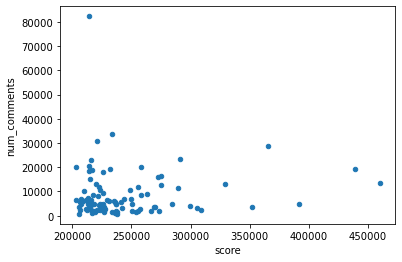

In [15]:
df.plot('score', 'num_comments', kind = 'scatter' )

# Analysis based on a r/marvelstudios

In [16]:
import matplotlib.pyplot as plt

In [17]:
marvel_df = get_posts('marvelstudios', 100) # This is where you can define any subreddit and 
                                            # run all the cells to get the network graph

In [10]:
marvel_df.author.nunique() # Out of 500, 373(new_NUMBER_SANKU) are unique 

77

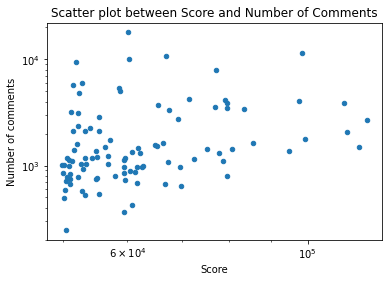

In [18]:
# See the relationship between comments and upvotes 
ax = marvel_df.plot('score', 'num_comments', kind = 'scatter',logx=True, logy=True, title='Scatter plot between Score and Number of Comments')
ax.set(xlabel="Score", ylabel="Number of comments")
plt.savefig("ScatterPlot",dpi=150, bbox_inches='tight',pad_inches=0.5)

In [19]:
repeating = marvel_df[marvel_df.duplicated(['author'], keep = False)] # Only take users who posted more than once

In [20]:
repeating = repeating[repeating.author != 'None'] # Get rid of deleted users

In [21]:
repeating.author.nunique() # Out of 500 posts, this is the amount of people who posted more than once 

4

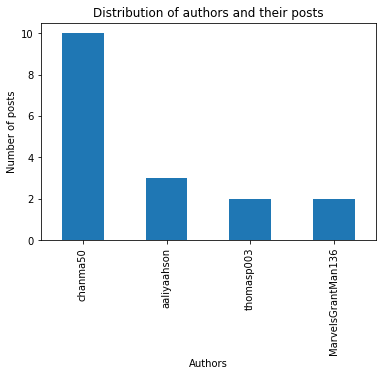

In [22]:
# See the distrubution of authors and their posts
ax = repeating.author.value_counts().plot(kind='bar',title='Distribution of authors and their posts') 
ax.set(xlabel="Authors", ylabel="Number of posts")
plt.savefig("Bargraph",dpi=150, bbox_inches='tight',pad_inches=0.5)

In [23]:
# Compiling a list of authors that appeared more than once on subreddit's top of all times 
# (Used for network graph and for get_user_posts function)
u_authors = list(repeating.author.unique()) 

In [24]:
authors_df =  pd.DataFrame() # Makes an empty dataframe
authors_df = authors_df.fillna(0)
for u in u_authors: # Loops through every "influencer" user and gets 10 top posts per user
    c = get_user_posts(u, 10)
    authors_df = pd.concat([authors_df, c]) 

In [25]:
authors_df = authors_df.rename(index=str, #renaming column names 
                               columns={0: "id", 1: "score", 2: "author", 3: "num_comments", 4: "subreddit"})

In [19]:
authors_df.head(10) # Dataframe of other subreddits where authors posted 

id   score    author  num_comments      subreddit
0  u27agl  103247  chanma50          4905         movies
1  pj9wf8   99207  chanma50          1796  marvelstudios
2  cgbt3j   96680  chanma50          4599         movies
3  dt3ejz   86184  chanma50          3814         movies
4  ihrk4f   82222  chanma50          1426         movies
5  pjqwpl   80174  chanma50          5299         movies
6  oa8a7i   80059  chanma50          4168         movies
7  kez0j2   79221  chanma50          3198         movies
8  lcgakt   79143  chanma50          1884         movies
9  pa3zrp   77821  chanma50          1310  marvelstudios

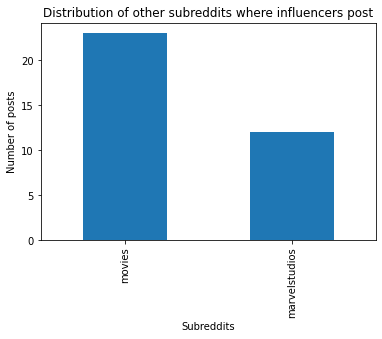

In [26]:
counts = authors_df['subreddit'].value_counts() 
# Only plot the subreddits that appear more than twice
ax = authors_df[authors_df['subreddit'].isin(counts[counts > 2].index)].subreddit.value_counts().plot(kind='bar',title='Distribution of other subreddits where influencers post') 
ax.set(xlabel="Subreddits", ylabel="Number of posts")
plt.savefig("BargraphSubreddits",dpi=150, bbox_inches='tight',pad_inches=0.5)

# Network Analysis

## Initial approach

In [27]:
n_df = authors_df[['author', 'subreddit']] # Create a dataframe for network graph purposes 
n_df.head()

author      subreddit
0  chanma50         movies
1  chanma50  marvelstudios
2  chanma50         movies
3  chanma50         movies
4  chanma50         movies

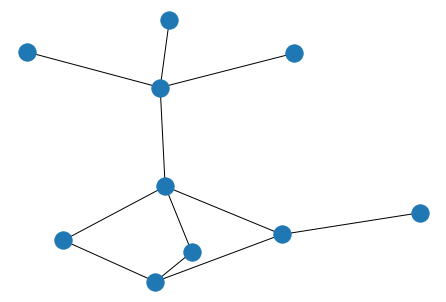

In [28]:
g = nx.from_pandas_edgelist(n_df, source='author', target='subreddit') # Initial ugly approach, decided to keep it
nx.draw(g)

## Final Approach

In [29]:
subs = list(n_df.subreddit.unique()) # Make list of unique subreddits to use in network graph 

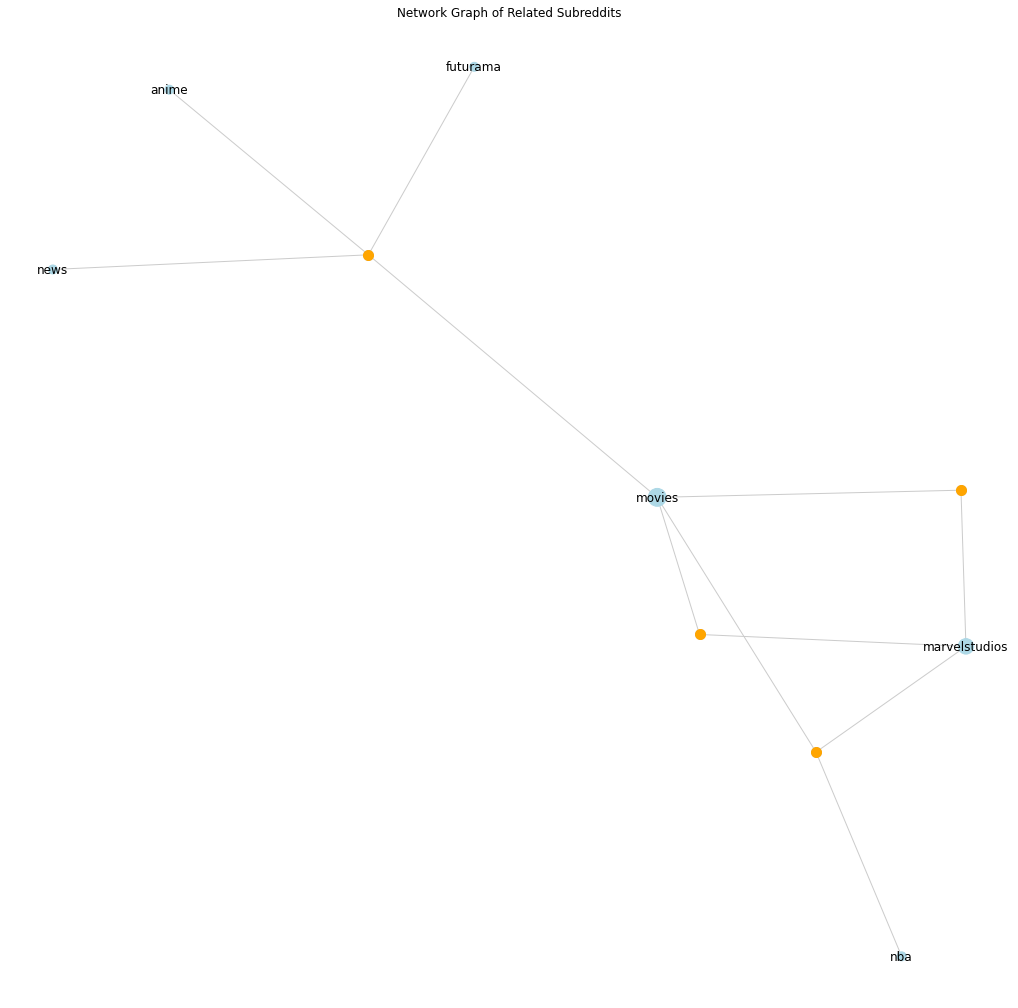

In [30]:
plt.figure(figsize=(18, 18))

# Create the graph from the dataframe
g = nx.from_pandas_edgelist(n_df, source='author', target='subreddit') 

# Create a layout for nodes 
layout = nx.spring_layout(g,iterations=50,scale=2)

# Draw the parts we want, edges thin and grey
# Influencers appear small and grey
# Subreddits appear in blue and sized according to their respective number of connections.
# Labels for subreddits ONLY
# People who have more connections are highlighted in color 

# Go through every subbreddit, ask the graph how many connections it has. 
# Multiply that by 80 to get the circle size
sub_size = [g.degree(sub) * 80 for sub in subs]
nx.draw_networkx_nodes(g, 
                       layout, 
                       nodelist=subs, 
                       node_size=sub_size, # a LIST of sizes, based on g.degree
                       node_color='lightblue')

# Draw all the entities 
nx.draw_networkx_nodes(g, layout, nodelist=u_authors, node_color='#cccccc', node_size=100)

# Draw highly connected influencers 
popular_people = [person for person in u_authors if g.degree(person) > 1]
nx.draw_networkx_nodes(g, layout, nodelist=popular_people, node_color='orange', node_size=100)

nx.draw_networkx_edges(g, layout, width=1, edge_color="#cccccc")

node_labels = dict(zip(subs, subs)) #labels for subs
nx.draw_networkx_labels(g, layout, labels=node_labels)

# No axis needed
plt.axis('off')
plt.title("Network Graph of Related Subreddits")
plt.savefig("NetworkGraph", bbox_inches='tight',pad_inches=0.5)
plt.show()

In [31]:
g.degree('movies') # To check the number of out-degrees for a subreddit, if interested 

4

In [32]:
import matplotlib.pyplot as plt

In [196]:
marvel_df = get_posts('india', 100) # This is where you can define any subreddit and 
                                            # run all the cells to get the network graph

In [197]:
marvel_df.author.nunique() 

83

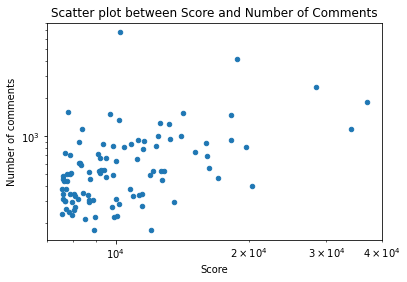

In [198]:
# See the relationship between comments and upvotes 
ax = marvel_df.plot('score', 'num_comments', kind = 'scatter',logx=True, logy=True, title='Scatter plot between Score and Number of Comments')
ax.set(xlabel="Score", ylabel="Number of comments")
plt.savefig("ScatterPlot",dpi=150, bbox_inches='tight',pad_inches=0.5)

In [199]:
repeating = marvel_df[marvel_df.duplicated(['author'], keep = False)] # Only take users who posted more than once

In [200]:
repeating = repeating[repeating.author != 'None'] # Get rid of deleted users

In [201]:
repeating.author.nunique() # Out of 500 posts, this is the amount of people who posted more than once 

7

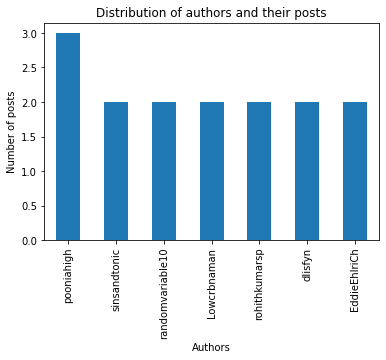

In [202]:
# See the distrubution of authors and their posts
ax = repeating.author.value_counts().plot(kind='bar',title='Distribution of authors and their posts') 
ax.set(xlabel="Authors", ylabel="Number of posts")
plt.savefig("Bargraph",dpi=150, bbox_inches='tight',pad_inches=0.5)

In [203]:
# Compiling a list of authors that appeared more than once on subreddit's top of all times 
# (Used for network graph and for get_user_posts function)
u_authors = list(repeating.author.unique()) 

In [204]:
authors_df =  pd.DataFrame() # Makes an empty dataframe
authors_df = authors_df.fillna(0)
for u in u_authors: # Loops through every "influencer" user and gets 10 top posts per user
    c = get_user_posts(u, 10)
    authors_df = pd.concat([authors_df, c]) 

Forbidden: received 403 HTTP response

In [36]:
authors_df = authors_df.rename(index=str, #renaming column names 
                               columns={0: "id", 1: "score", 2: "author", 3: "num_comments", 4: "subreddit"})

In [37]:
authors_df.head(10) # Dataframe of other subreddits where authors posted 

id   score    author  num_comments      subreddit
0  u27agl  103243  chanma50          4905         movies
1  pj9wf8   99200  chanma50          1796  marvelstudios
2  cgbt3j   96684  chanma50          4599         movies
3  dt3ejz   86186  chanma50          3814         movies
4  ihrk4f   82232  chanma50          1426         movies
5  pjqwpl   80173  chanma50          5299         movies
6  oa8a7i   80056  chanma50          4168         movies
7  kez0j2   79221  chanma50          3198         movies
8  lcgakt   79140  chanma50          1884         movies
9  pa3zrp   77835  chanma50          1310  marvelstudios

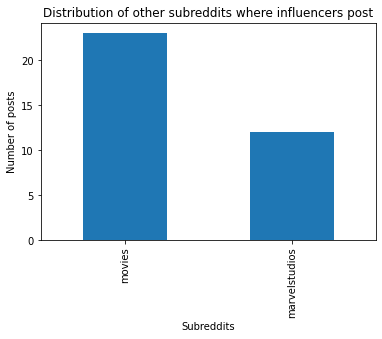

In [38]:
counts = authors_df['subreddit'].value_counts() 
# Only plot the subreddits that appear more than twice
ax = authors_df[authors_df['subreddit'].isin(counts[counts > 2].index)].subreddit.value_counts().plot(kind='bar',title='Distribution of other subreddits where influencers post') 
ax.set(xlabel="Subreddits", ylabel="Number of posts")
plt.savefig("BargraphSubreddits",dpi=150, bbox_inches='tight',pad_inches=0.5)

# Network Analysis

## Initial approach

In [39]:
n_df = authors_df[['author', 'subreddit']] # Create a dataframe for network graph purposes 
n_df.head()

author      subreddit
0  chanma50         movies
1  chanma50  marvelstudios
2  chanma50         movies
3  chanma50         movies
4  chanma50         movies

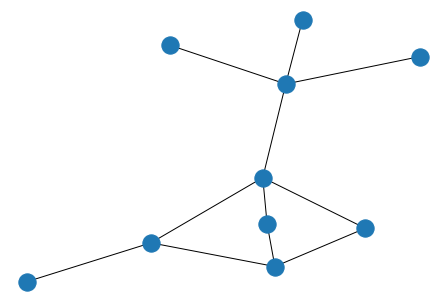

In [40]:
g = nx.from_pandas_edgelist(n_df, source='author', target='subreddit') # Initial ugly approach, decided to keep it
nx.draw(g)

## Final Approach

In [41]:
subs = list(n_df.subreddit.unique()) # Make list of unique subreddits to use in network graph 

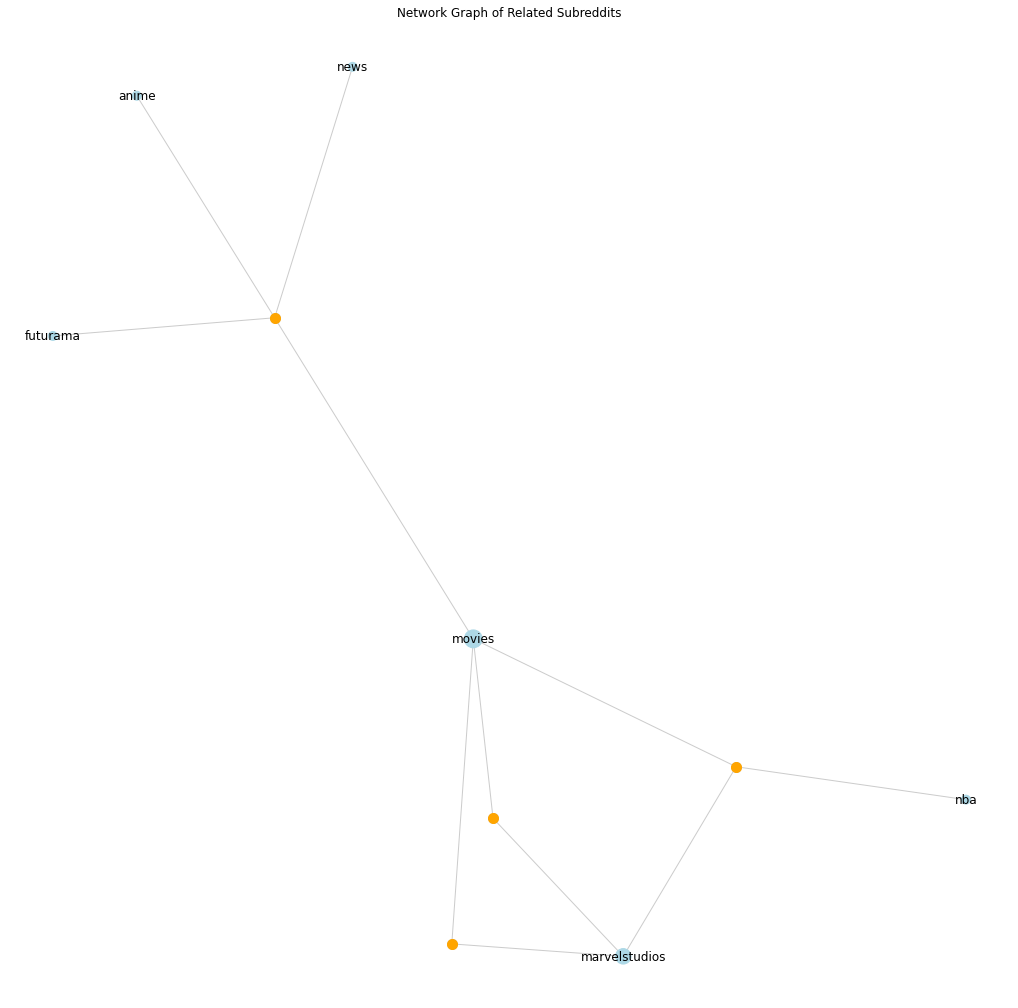

In [42]:
plt.figure(figsize=(18, 18))

# Create the graph from the dataframe
g = nx.from_pandas_edgelist(n_df, source='author', target='subreddit') 

# Create a layout for nodes 
layout = nx.spring_layout(g,iterations=50,scale=2)

# Draw the parts we want, edges thin and grey
# Influencers appear small and grey
# Subreddits appear in blue and sized according to their respective number of connections.
# Labels for subreddits ONLY
# People who have more connections are highlighted in color 

# Go through every subbreddit, ask the graph how many connections it has. 
# Multiply that by 80 to get the circle size
sub_size = [g.degree(sub) * 80 for sub in subs]
nx.draw_networkx_nodes(g, 
                       layout, 
                       nodelist=subs, 
                       node_size=sub_size, # a LIST of sizes, based on g.degree
                       node_color='lightblue')

# Draw all the entities 
nx.draw_networkx_nodes(g, layout, nodelist=u_authors, node_color='#cccccc', node_size=100)

# Draw highly connected influencers 
popular_people = [person for person in u_authors if g.degree(person) > 1]
nx.draw_networkx_nodes(g, layout, nodelist=popular_people, node_color='orange', node_size=100)

nx.draw_networkx_edges(g, layout, width=1, edge_color="#cccccc")

node_labels = dict(zip(subs, subs)) #labels for subs
nx.draw_networkx_labels(g, layout, labels=node_labels)

# No axis needed
plt.axis('off')
plt.title("Network Graph of Related Subreddits")
plt.savefig("NetworkGraph", bbox_inches='tight',pad_inches=0.5)
plt.show()

In [43]:
g.degree('movies') # To check the number of out-degrees for a subreddit, if interested 

4

In [34]:
a=nx.degree_centrality(g)
print(a)

{'chanma50': 0.2222222222222222, 'movies': 0.4444444444444444, 'marvelstudios': 0.3333333333333333, 'aaliyaahson': 0.3333333333333333, 'nba': 0.1111111111111111, 'thomasp003': 0.2222222222222222, 'MarvelsGrantMan136': 0.4444444444444444, 'news': 0.1111111111111111, 'futurama': 0.1111111111111111, 'anime': 0.1111111111111111}


In [35]:
b=nx.closeness_centrality(g)
print(b)

{'chanma50': 0.45, 'movies': 0.6428571428571429, 'marvelstudios': 0.4090909090909091, 'aaliyaahson': 0.5, 'nba': 0.34615384615384615, 'thomasp003': 0.45, 'MarvelsGrantMan136': 0.5625, 'news': 0.375, 'futurama': 0.375, 'anime': 0.375}


In [36]:
c=nx.betweenness_centrality(g)
print(c)

{'chanma50': 0.0462962962962963, 'movies': 0.625, 'marvelstudios': 0.06944444444444445, 'aaliyaahson': 0.2685185185185185, 'nba': 0.0, 'thomasp003': 0.0462962962962963, 'MarvelsGrantMan136': 0.5833333333333333, 'news': 0.0, 'futurama': 0.0, 'anime': 0.0}


In [37]:
d=nx.edge_betweenness_centrality(g)
print(d)

{('chanma50', 'movies'): 0.18148148148148152, ('chanma50', 'marvelstudios'): 0.09259259259259259, ('movies', 'aaliyaahson'): 0.30370370370370364, ('movies', 'thomasp003'): 0.18148148148148152, ('movies', 'MarvelsGrantMan136'): 0.5333333333333333, ('marvelstudios', 'aaliyaahson'): 0.12592592592592597, ('marvelstudios', 'thomasp003'): 0.09259259259259259, ('aaliyaahson', 'nba'): 0.2, ('MarvelsGrantMan136', 'news'): 0.2, ('MarvelsGrantMan136', 'futurama'): 0.2, ('MarvelsGrantMan136', 'anime'): 0.2}


In [38]:
e=nx.voterank(g)
print(e)

['movies', 'MarvelsGrantMan136', 'aaliyaahson', 'marvelstudios']


In [39]:
f=nx.pagerank(g)
print(f)

{'chanma50': 0.08513128527518583, 'movies': 0.16484146872025807, 'marvelstudios': 0.12389347748539012, 'aaliyaahson': 0.1289324711756194, 'nba': 0.051531206221685055, 'thomasp003': 0.08513128527518583, 'MarvelsGrantMan136': 0.19269483214207175, 'news': 0.05594799123486793, 'futurama': 0.05594799123486793, 'anime': 0.05594799123486793}


<BarContainer object of 10 artists>

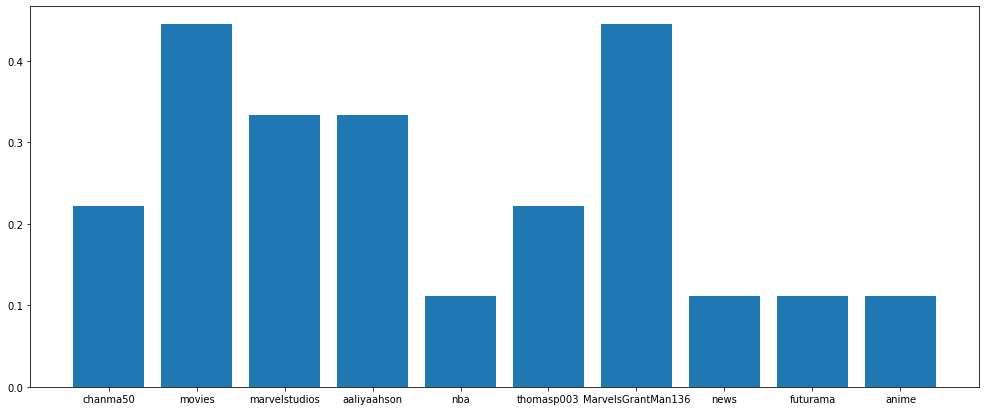

In [40]:
names, counts = zip(*a.items())
plt.figure(figsize=(17,7))
plt.bar(names, counts)

In [61]:
marvel_df1 = get_posts('covidlonghaulers', 100) # This is where you can define any subreddit and 
                                            # run all the cells to get the network graph

In [62]:
marvel_df1.author.nunique() # Out of 500, 373(new_NUMBER_SANKU) are unique 

82

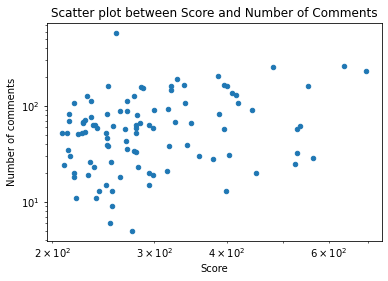

In [63]:
# See the relationship between comments and upvotes 
ax = marvel_df1.plot('score', 'num_comments', kind = 'scatter',logx=True, logy=True, title='Scatter plot between Score and Number of Comments')
ax.set(xlabel="Score", ylabel="Number of comments")
plt.savefig("ScatterPlot",dpi=150, bbox_inches='tight',pad_inches=0.5)

In [64]:
repeating1 = marvel_df1[marvel_df1.duplicated(['author'], keep = False)] # Only take users who posted more than once

In [65]:
repeating1 = repeating1[repeating1.author != 'None'] # Get rid of deleted users

In [66]:
repeating1.author.nunique() # Out of 500 posts, this is the amount of people who posted more than once 

8

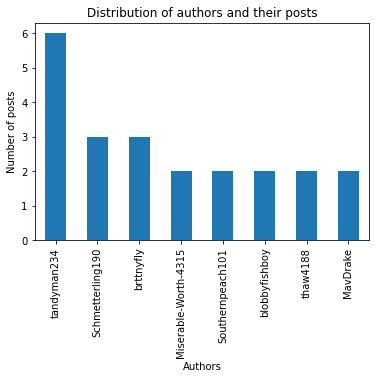

In [67]:
# See the distrubution of authors and their posts
ax = repeating1.author.value_counts().plot(kind='bar',title='Distribution of authors and their posts') 
ax.set(xlabel="Authors", ylabel="Number of posts")
plt.savefig("Bargraph",dpi=150, bbox_inches='tight',pad_inches=0.5)

In [68]:
# Compiling a list of authors that appeared more than once on subreddit's top of all times 
# (Used for network graph and for get_user_posts function)
u_authors1 = list(repeating1.author.unique()) 

In [69]:
authors_df1 =  pd.DataFrame() # Makes an empty dataframe
authors_df1 = authors_df1.fillna(0)
for u in u_authors1: # Loops through every "influencer" user and gets 10 top posts per user
    c = get_user_posts(u, 10)
    authors_df1 = pd.concat([authors_df1, c]) 

In [70]:
authors_df1 = authors_df1.rename(index=str, #renaming column names 
                               columns={0: "id", 1: "score", 2: "author", 3: "num_comments", 4: "subreddit"})

In [71]:
authors_df1.head(10) # Dataframe of other subreddits where authors posted 

id   score       author  num_comments             subreddit
0  s2myx5  149061  tandyman234          5611  Damnthatsinteresting
1  pip0m7  147719  tandyman234          8771     interestingasfuck
2  nhxk7w  108259  tandyman234          2153                  pics
3  rh9f23  104416  tandyman234          1539     interestingasfuck
4  pkx2yo  100602  tandyman234          1095           MadeMeSmile
5  qqe4ca   92207  tandyman234          1267           MadeMeSmile
6  qq673j   83407  tandyman234           945           MadeMeSmile
7  ienkq2   74161  tandyman234         17903             AskReddit
8  s4478m   73276  tandyman234           323       oddlysatisfying
9  j07uko   70468  tandyman234          1677     interestingasfuck

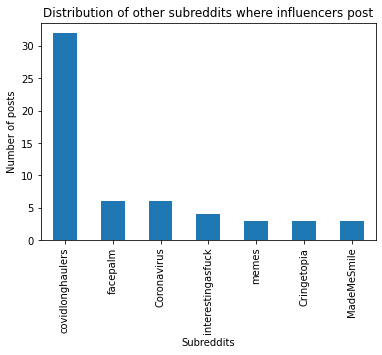

In [72]:
counts = authors_df1['subreddit'].value_counts() 
# Only plot the subreddits that appear more than twice
ax = authors_df1[authors_df1['subreddit'].isin(counts[counts > 2].index)].subreddit.value_counts().plot(kind='bar',title='Distribution of other subreddits where influencers post') 
ax.set(xlabel="Subreddits", ylabel="Number of posts")
plt.savefig("BargraphSubreddits",dpi=150, bbox_inches='tight',pad_inches=0.5)

In [73]:
n_df1 = authors_df1[['author', 'subreddit']] # Create a dataframe for network graph purposes 
n_df1.head()

author             subreddit
0  tandyman234  Damnthatsinteresting
1  tandyman234     interestingasfuck
2  tandyman234                  pics
3  tandyman234     interestingasfuck
4  tandyman234           MadeMeSmile

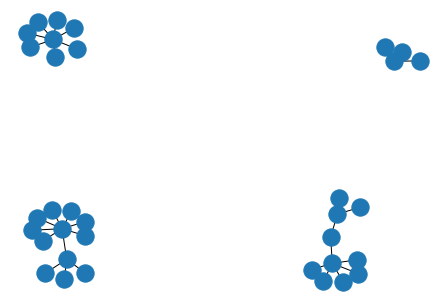

In [74]:
g1 = nx.from_pandas_edgelist(n_df1, source='author', target='subreddit') # Initial ugly approach, decided to keep it
nx.draw(g1)

## Final Approach

In [75]:
subs1 = list(n_df1.subreddit.unique()) # Make list of unique subreddits to use in network graph 

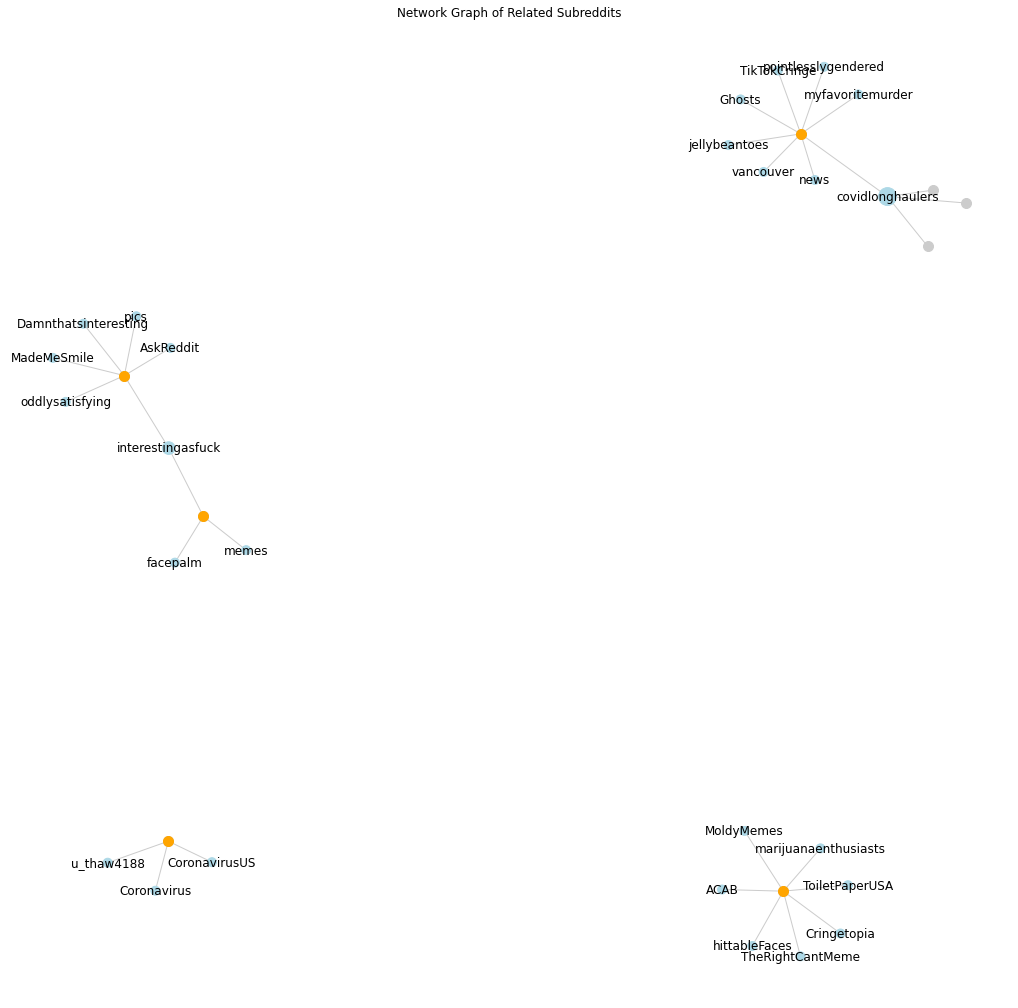

In [76]:
plt.figure(figsize=(18, 18))

# Create the graph from the dataframe
g1 = nx.from_pandas_edgelist(n_df1, source='author', target='subreddit') 

# Create a layout for nodes 
layout = nx.spring_layout(g1,iterations=50,scale=2)

# Draw the parts we want, edges thin and grey
# Influencers appear small and grey
# Subreddits appear in blue and sized according to their respective number of connections.
# Labels for subreddits ONLY
# People who have more connections are highlighted in color 

# Go through every subbreddit, ask the graph how many connections it has. 
# Multiply that by 80 to get the circle size
sub_size = [g1.degree(sub) * 80 for sub in subs1]
nx.draw_networkx_nodes(g1, 
                       layout, 
                       nodelist=subs1, 
                       node_size=sub_size, # a LIST of sizes, based on g.degree
                       node_color='lightblue')

# Draw all the entities 
nx.draw_networkx_nodes(g1, layout, nodelist=u_authors1, node_color='#cccccc', node_size=100)

# Draw highly connected influencers 
popular_people = [person for person in u_authors1 if g1.degree(person) > 1]
nx.draw_networkx_nodes(g1, layout, nodelist=popular_people, node_color='orange', node_size=100)

nx.draw_networkx_edges(g1, layout, width=1, edge_color="#cccccc")

node_labels = dict(zip(subs1, subs1)) #labels for subs
nx.draw_networkx_labels(g1, layout, labels=node_labels)

# No axis needed
plt.axis('off')
plt.title("Network Graph of Related Subreddits")
plt.savefig("NetworkGraph", bbox_inches='tight',pad_inches=0.5)
plt.show()

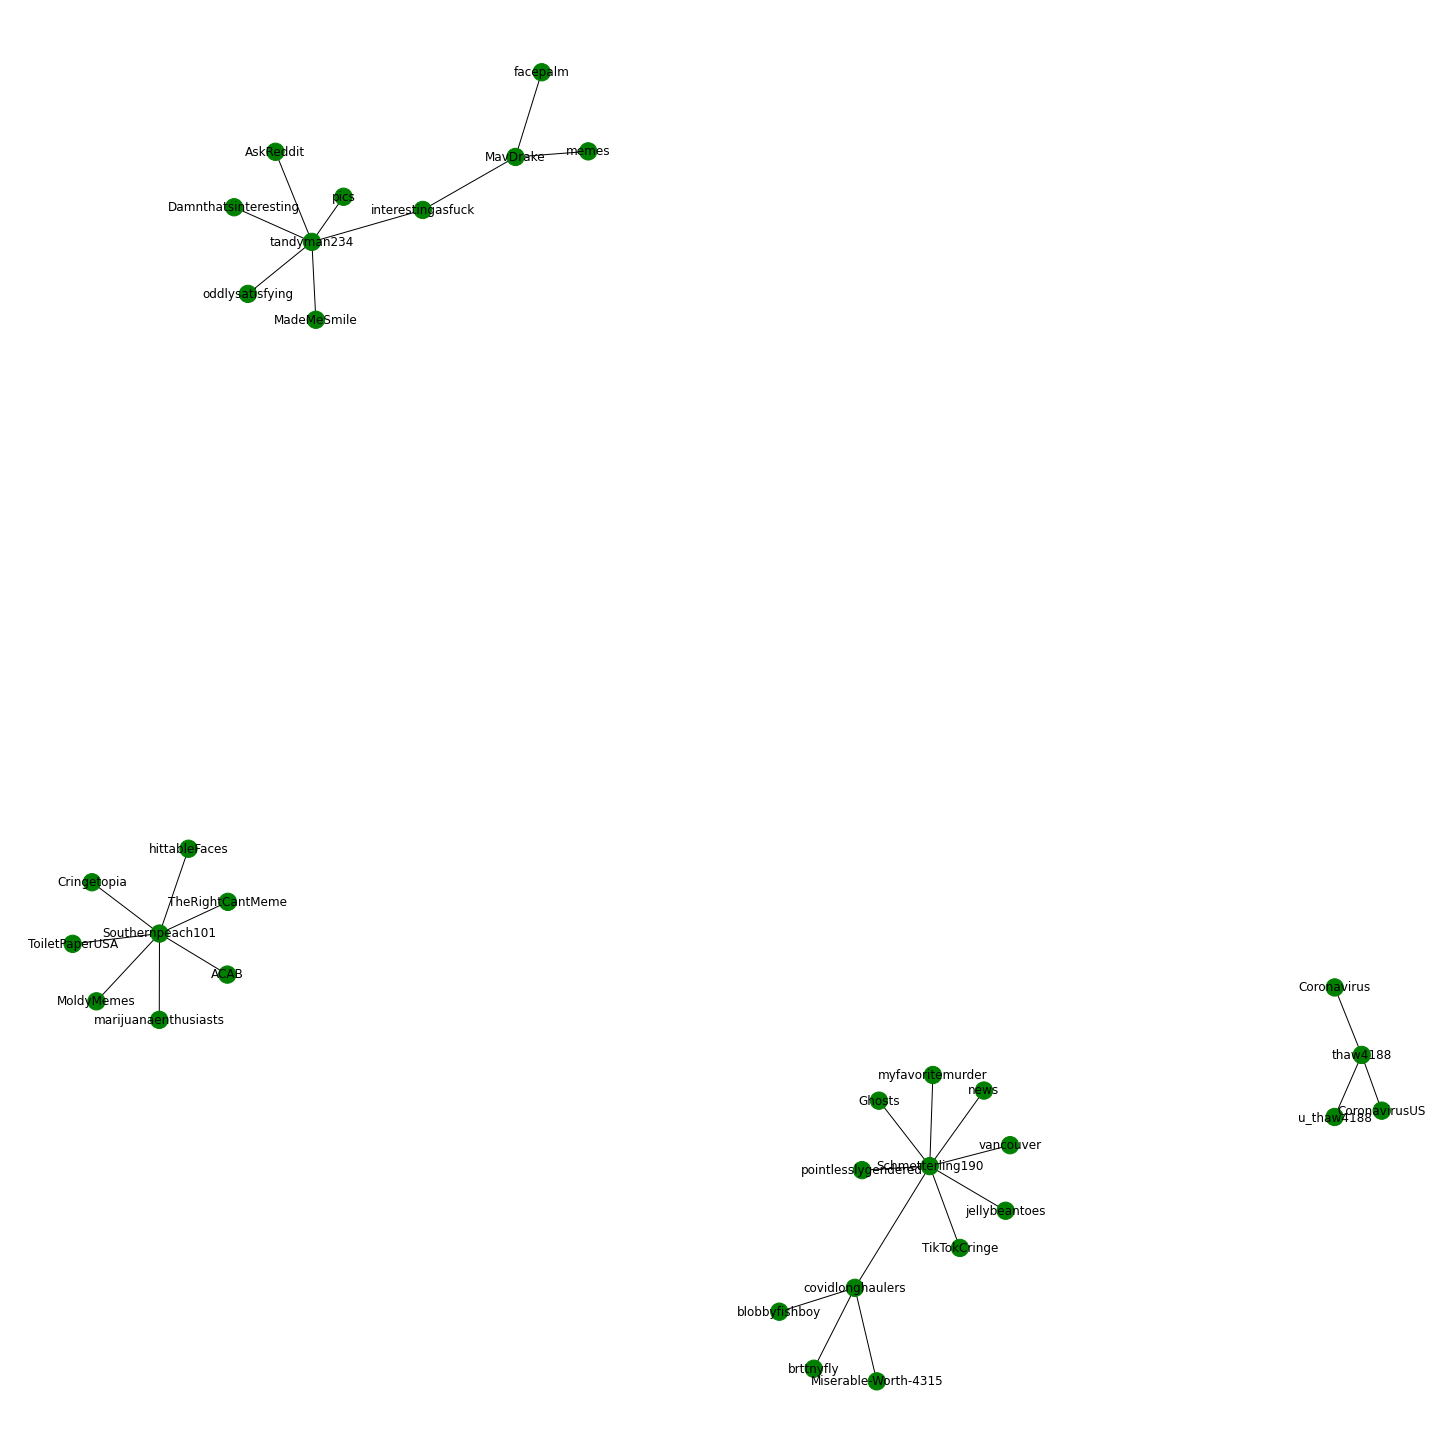

In [256]:
# plot the communities
plt.figure(figsize=(20, 20))
color_map = []
for node in g1:
    if node in node_groups[0]:
        color_map.append('green')
    else: 
        color_map.append('green')  

nx.draw(g1, node_color=color_map, with_labels=True)
plt.show()

# Subreddit 3

In [77]:
import matplotlib.pyplot as plt

In [78]:
marvel_df = get_posts('masks4all', 100) # This is where you can define any subreddit and 
                                            # run all the cells to get the network graph

In [79]:
marvel_df.author.nunique() # Out of 500, 373(new_NUMBER_SANKU) are unique 

80

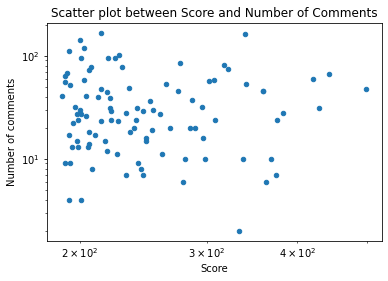

In [80]:
# See the relationship between comments and upvotes 
ax = marvel_df.plot('score', 'num_comments', kind = 'scatter',logx=True, logy=True, title='Scatter plot between Score and Number of Comments')
ax.set(xlabel="Score", ylabel="Number of comments")
plt.savefig("ScatterPlot",dpi=150, bbox_inches='tight',pad_inches=0.5)

In [81]:
repeating = marvel_df[marvel_df.duplicated(['author'], keep = False)] # Only take users who posted more than once

In [82]:
repeating = repeating[repeating.author != 'None'] # Get rid of deleted users

In [83]:
repeating.author.nunique() # Out of 500 posts, this is the amount of people who posted more than once 

11

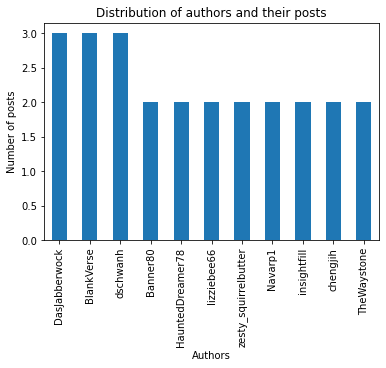

In [84]:
# See the distrubution of authors and their posts
ax = repeating.author.value_counts().plot(kind='bar',title='Distribution of authors and their posts') 
ax.set(xlabel="Authors", ylabel="Number of posts")
plt.savefig("Bargraph",dpi=150, bbox_inches='tight',pad_inches=0.5)

In [85]:
# Compiling a list of authors that appeared more than once on subreddit's top of all times 
# (Used for network graph and for get_user_posts function)
u_authors = list(repeating.author.unique()) 

In [86]:
authors_df =  pd.DataFrame() # Makes an empty dataframe
authors_df = authors_df.fillna(0)
for u in u_authors: # Loops through every "influencer" user and gets 10 top posts per user
    c = get_user_posts(u, 10)
    authors_df = pd.concat([authors_df, c]) 

In [87]:
authors_df = authors_df.rename(index=str, #renaming column names 
                               columns={0: "id", 1: "score", 2: "author", 3: "num_comments", 4: "subreddit"})

In [88]:
authors_df.head(10) # Dataframe of other subreddits where authors posted 

id  score                author  num_comments             subreddit
0  lg5h4o   5405  zesty_squirrelbutter           337               popping
1  htupup   2695  zesty_squirrelbutter           127    religiousfruitcake
2  kgou74   2150  zesty_squirrelbutter            71        AwesomeCarMods
3  hvx3h1   1408  zesty_squirrelbutter            19  AnimalsBeingGeniuses
4  l7gfjx   1001  zesty_squirrelbutter           132         antifeminists
5  itq0qf    903  zesty_squirrelbutter            52              eyeblech
6  ht0p0c    578  zesty_squirrelbutter           119   simpsonsshitposting
7  ht8gwo    438  zesty_squirrelbutter            12      Bad_Cop_No_Donut
8  i367pw    302  zesty_squirrelbutter            57             Masks4All
9  ikwhrl    230  zesty_squirrelbutter             4        Idiotswithguns

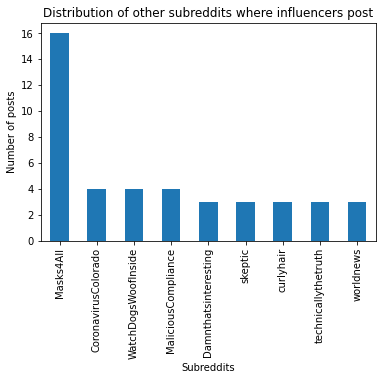

In [89]:
counts = authors_df['subreddit'].value_counts() 
# Only plot the subreddits that appear more than twice
ax = authors_df[authors_df['subreddit'].isin(counts[counts > 2].index)].subreddit.value_counts().plot(kind='bar',title='Distribution of other subreddits where influencers post') 
ax.set(xlabel="Subreddits", ylabel="Number of posts")
plt.savefig("BargraphSubreddits",dpi=150, bbox_inches='tight',pad_inches=0.5)

# Network Analysis

## Initial approach

In [90]:
n_df = authors_df[['author', 'subreddit']] # Create a dataframe for network graph purposes 
n_df.head()

author             subreddit
0  zesty_squirrelbutter               popping
1  zesty_squirrelbutter    religiousfruitcake
2  zesty_squirrelbutter        AwesomeCarMods
3  zesty_squirrelbutter  AnimalsBeingGeniuses
4  zesty_squirrelbutter         antifeminists

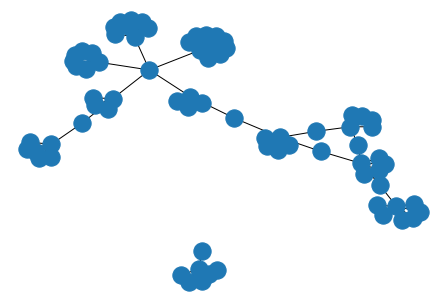

In [91]:
g = nx.from_pandas_edgelist(n_df, source='author', target='subreddit') # Initial ugly approach, decided to keep it
nx.draw(g)

## Final Approach

In [92]:
subs = list(n_df.subreddit.unique()) # Make list of unique subreddits to use in network graph 

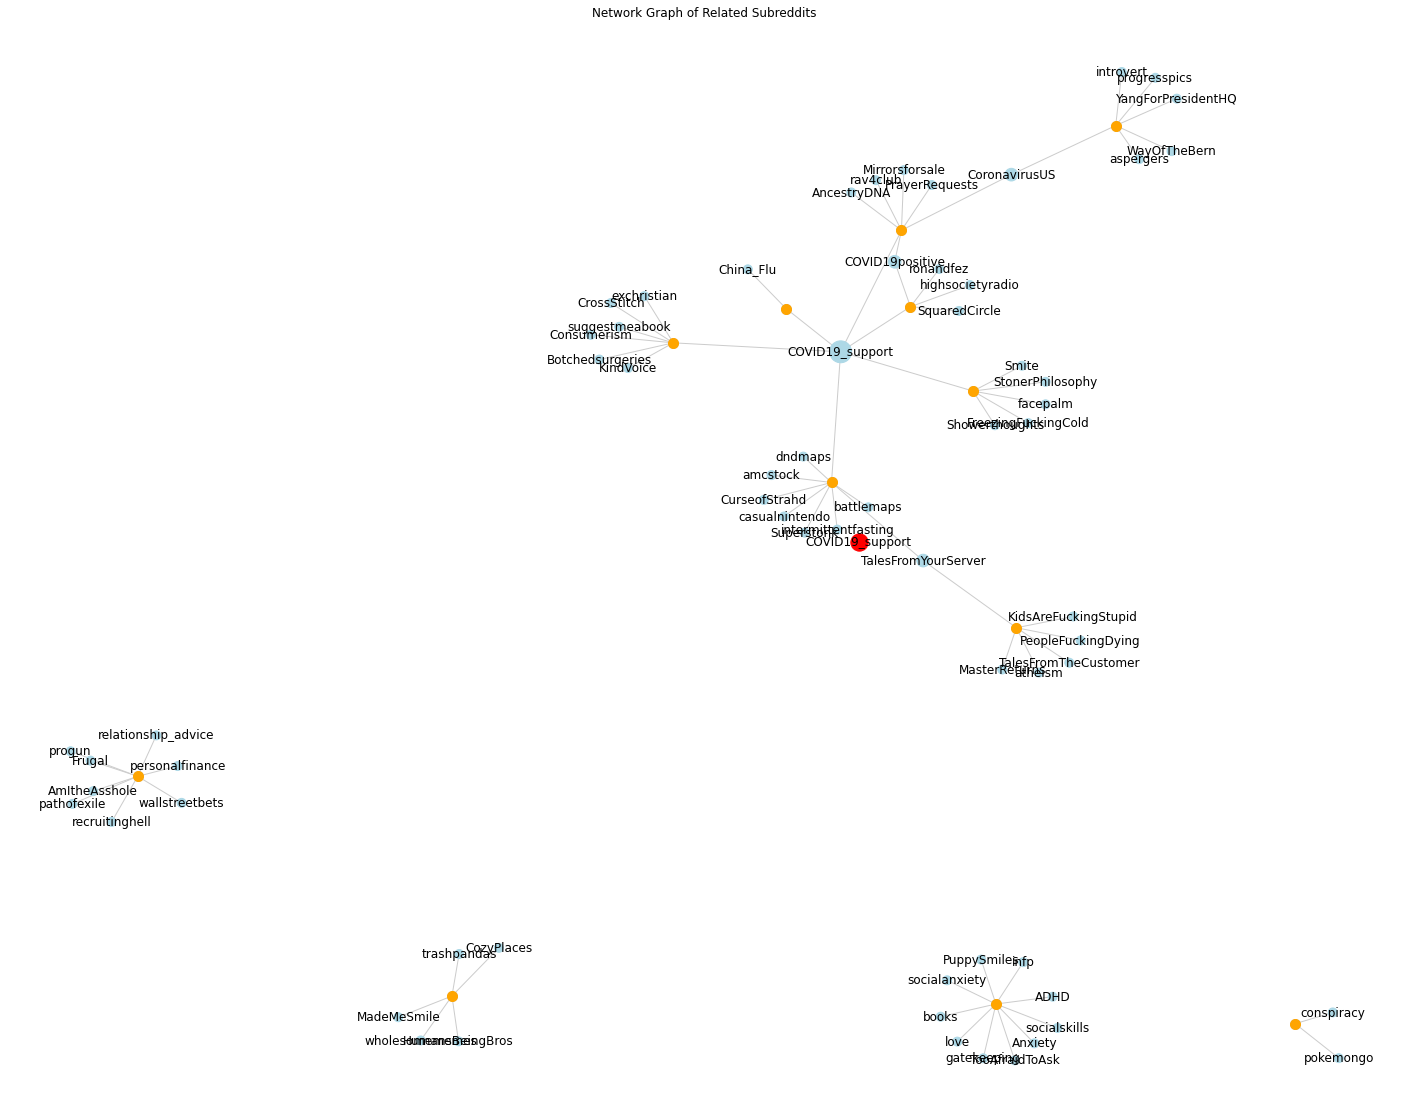

In [260]:
plt.figure(figsize=(25, 20))

# Create the graph from the dataframe
g = nx.from_pandas_edgelist(n_df, source='author', target='subreddit') 

# Create a layout for nodes 
layout = nx.spring_layout(g,iterations=50,scale=2)
pos=nx.spring_layout(g)

# Draw the parts we want, edges thin and grey
# Influencers appear small and grey
# Subreddits appear in blue and sized according to their respective number of connections.
# Labels for subreddits ONLY
# People who have more connections are highlighted in color 

# Go through every subbreddit, ask the graph how many connections it has. 
# Multiply that by 80 to get the circle size
sub_size = [g.degree(sub) * 80 for sub in subs]
nx.draw_networkx_nodes(g, 
                       layout, 
                       nodelist=subs, 
                       node_size=sub_size, # a LIST of sizes, based on g.degree
                       node_color='lightblue')

# Draw all the entities 
nx.draw_networkx_nodes(g, layout, nodelist=u_authors, node_color='#cccccc', node_size=100)

# Draw highly connected influencers 
popular_people = [person for person in u_authors if g.degree(person) > 1]
nx.draw_networkx_nodes(g, layout, nodelist=popular_people, node_color='orange', node_size=100)

nx.draw_networkx_edges(g, layout, width=1, edge_color="#cccccc")

node_labels = dict(zip(subs, subs)) #labels for subs
nx.draw_networkx_labels(g, layout, labels=node_labels)
nx.draw_networkx(g.subgraph('COVID19_support'),pos=pos,node_color='red')

# No axis needed
plt.axis('off')
plt.title("Network Graph of Related Subreddits")
plt.savefig("NetworkGraph", bbox_inches='tight',pad_inches=0.8)
plt.show()

In [261]:
g.degree('COVID19_support') # To check the number of out-degrees for a subreddit, if interested 

6

In [190]:
a=nx.degree_centrality(g)
print(a)

{'zesty_squirrelbutter': 0.13513513513513514, 'popping': 0.013513513513513514, 'religiousfruitcake': 0.013513513513513514, 'AwesomeCarMods': 0.013513513513513514, 'AnimalsBeingGeniuses': 0.013513513513513514, 'antifeminists': 0.013513513513513514, 'eyeblech': 0.013513513513513514, 'simpsonsshitposting': 0.013513513513513514, 'Bad_Cop_No_Donut': 0.013513513513513514, 'Masks4All': 0.06756756756756757, 'Idiotswithguns': 0.013513513513513514, 'dschwanh': 0.0945945945945946, 'pics': 0.02702702702702703, 'PoliticalHumor': 0.013513513513513514, 'Damnthatsinteresting': 0.02702702702702703, 'surrealmemes': 0.013513513513513514, 'technicallythetruth': 0.013513513513513514, 'funny': 0.013513513513513514, 'curlyhair': 0.02702702702702703, 'DasJabberwock': 0.06756756756756757, 'see': 0.013513513513513514, 'Portland': 0.013513513513513514, 'glutenfreerecipes': 0.013513513513513514, 'lizziebee66': 0.08108108108108109, 'entitledparents': 0.02702702702702703, 'pettyrevenge': 0.013513513513513514, 'Mali

In [117]:
b=nx.closeness_centrality(g)
print(b)

{'zesty_squirrelbutter': 0.2106325075075075, 'popping': 0.1713620400061078, 'religiousfruitcake': 0.1713620400061078, 'AwesomeCarMods': 0.1713620400061078, 'AnimalsBeingGeniuses': 0.1713620400061078, 'antifeminists': 0.1713620400061078, 'eyeblech': 0.1713620400061078, 'simpsonsshitposting': 0.1713620400061078, 'Bad_Cop_No_Donut': 0.1713620400061078, 'Masks4All': 0.252759009009009, 'Idiotswithguns': 0.1713620400061078, 'dschwanh': 0.21979044261652955, 'pics': 0.19319159924255466, 'PoliticalHumor': 0.17737474316421684, 'Damnthatsinteresting': 0.18382473382473383, 'surrealmemes': 0.17737474316421684, 'technicallythetruth': 0.17737474316421684, 'funny': 0.17737474316421684, 'curlyhair': 0.2333160083160083, 'DasJabberwock': 0.24659415513074048, 'see': 0.19443000693000692, 'Portland': 0.19443000693000692, 'glutenfreerecipes': 0.19443000693000692, 'lizziebee66': 0.15318727818727818, 'entitledparents': 0.17841812400635929, 'pettyrevenge': 0.1313033813033813, 'MaliciousCompliance': 0.1313033813

In [97]:
c=nx.betweenness_centrality(g)
print(c)

{'zesty_squirrelbutter': 0.20659015179563125, 'popping': 0.0, 'religiousfruitcake': 0.0, 'AwesomeCarMods': 0.0, 'AnimalsBeingGeniuses': 0.0, 'antifeminists': 0.0, 'eyeblech': 0.0, 'simpsonsshitposting': 0.0, 'Bad_Cop_No_Donut': 0.0, 'Masks4All': 0.5912624953720844, 'Idiotswithguns': 0.0, 'dschwanh': 0.4257682339874121, 'pics': 0.23731951129211404, 'PoliticalHumor': 0.0, 'Damnthatsinteresting': 0.09663087745279526, 'surrealmemes': 0.0, 'technicallythetruth': 0.0, 'funny': 0.0, 'curlyhair': 0.3946686412439837, 'DasJabberwock': 0.4420584968530174, 'see': 0.0, 'Portland': 0.0, 'glutenfreerecipes': 0.0, 'lizziebee66': 0.11847463902258423, 'entitledparents': 0.13550536838208072, 'pettyrevenge': 0.0, 'MaliciousCompliance': 0.0, 'IDontWorkHereLady': 0.0, 'tea': 0.0, 'blackcats': 0.0, 'BlankVerse': 0.2684191040355424, 'nottheonion': 0.027397260273972605, 'politics': 0.0, 'worldnews': 0.0, 'news': 0.0, 'science': 0.1554979637171418, 'u_BlankVerse': 0.0, 'HauntedDreamer78': 0.21991854868567198, '

In [98]:
d=nx.edge_betweenness_centrality(g)
print(d)

{('zesty_squirrelbutter', 'popping'): 0.024144144144144144, ('zesty_squirrelbutter', 'religiousfruitcake'): 0.024144144144144144, ('zesty_squirrelbutter', 'AwesomeCarMods'): 0.024144144144144144, ('zesty_squirrelbutter', 'AnimalsBeingGeniuses'): 0.024144144144144144, ('zesty_squirrelbutter', 'antifeminists'): 0.024144144144144144, ('zesty_squirrelbutter', 'eyeblech'): 0.024144144144144144, ('zesty_squirrelbutter', 'simpsonsshitposting'): 0.024144144144144144, ('zesty_squirrelbutter', 'Bad_Cop_No_Donut'): 0.024144144144144144, ('zesty_squirrelbutter', 'Masks4All'): 0.209009009009009, ('zesty_squirrelbutter', 'Idiotswithguns'): 0.024144144144144144, ('Masks4All', 'DasJabberwock'): 0.41333333333333333, ('Masks4All', 'HauntedDreamer78'): 0.22594594594594594, ('Masks4All', 'chengjih'): 0.15387387387387388, ('Masks4All', 'Navarp1'): 0.17297297297297298, ('dschwanh', 'pics'): 0.2491891891891892, ('dschwanh', 'PoliticalHumor'): 0.024144144144144144, ('dschwanh', 'Damnthatsinteresting'): 0.1136

In [99]:
e=nx.voterank(g)
print(e)

['zesty_squirrelbutter', 'Navarp1', 'dschwanh', 'TheWaystone', 'lizziebee66', 'insightfill', 'chengjih', 'BlankVerse', 'Banner80', 'DasJabberwock', 'HauntedDreamer78']


In [100]:
f=nx.pagerank(g)
print(f)

{'zesty_squirrelbutter': 0.06338748915191594, 'popping': 0.007387532401405708, 'religiousfruitcake': 0.007387532401405708, 'AwesomeCarMods': 0.007387532401405708, 'AnimalsBeingGeniuses': 0.007387532401405708, 'antifeminists': 0.007387532401405708, 'eyeblech': 0.007387532401405708, 'simpsonsshitposting': 0.007387532401405708, 'Bad_Cop_No_Donut': 0.007387532401405708, 'Masks4All': 0.028640152301729845, 'Idiotswithguns': 0.007387532401405708, 'dschwanh': 0.04149745607105626, 'pics': 0.012126998026056476, 'PoliticalHumor': 0.007038588446089856, 'Damnthatsinteresting': 0.012308968081862026, 'surrealmemes': 0.007038588446089856, 'technicallythetruth': 0.007038588446089856, 'funny': 0.007038588446089856, 'curlyhair': 0.012184119871833005, 'DasJabberwock': 0.030270165218575926, 'see': 0.007145531425743149, 'Portland': 0.007145531425743149, 'glutenfreerecipes': 0.007145531425743149, 'lizziebee66': 0.04020687490570032, 'entitledparents': 0.012937144530190167, 'pettyrevenge': 0.00769557510220926,

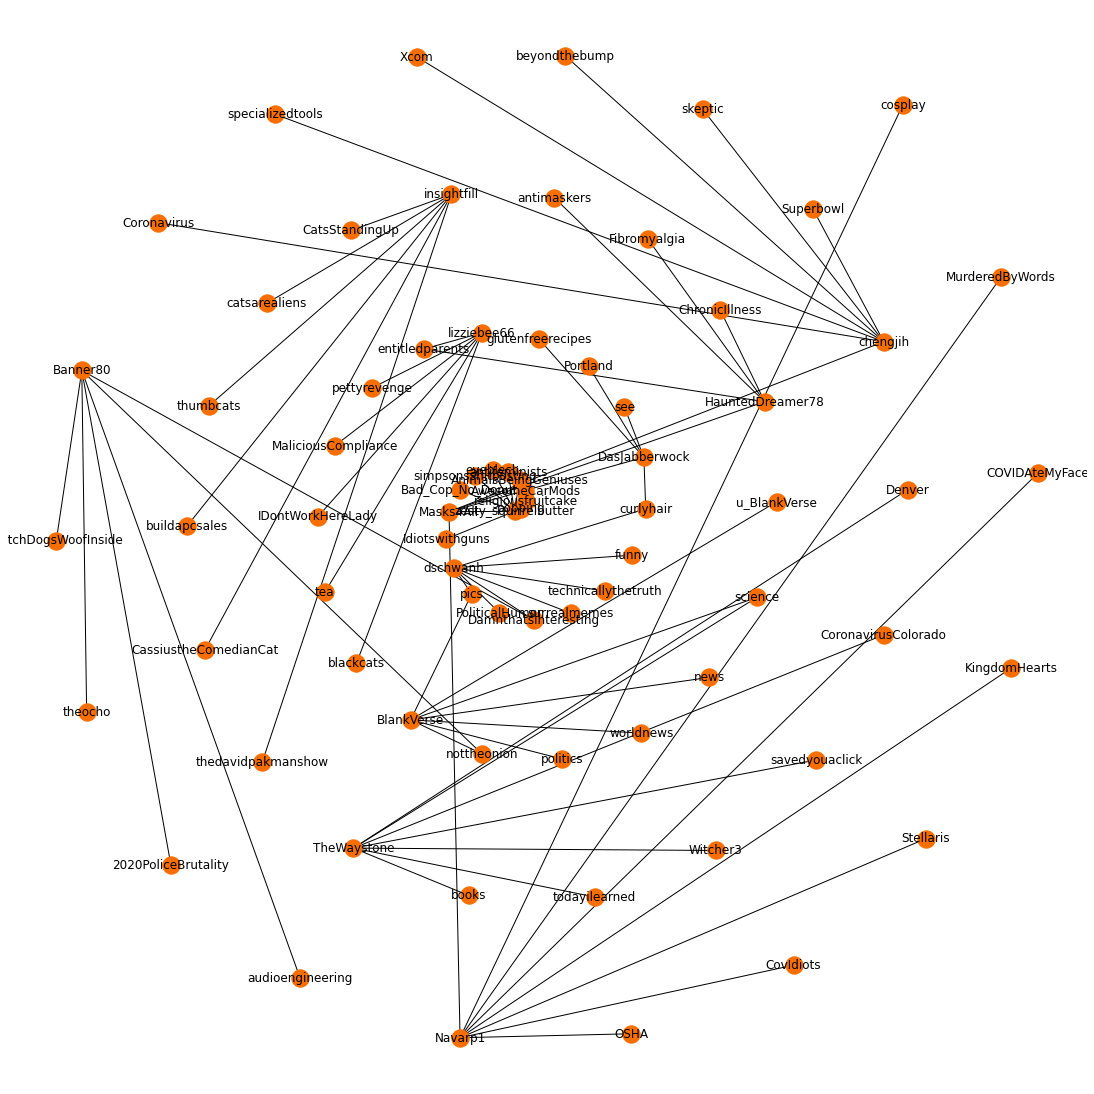

In [214]:
pos = nx.spiral_layout(g)
plt.figure(figsize=(15,15))
nx.draw(g, pos, with_labels = True, node_color="#f86e00")
plt.show()

<BarContainer object of 75 artists>

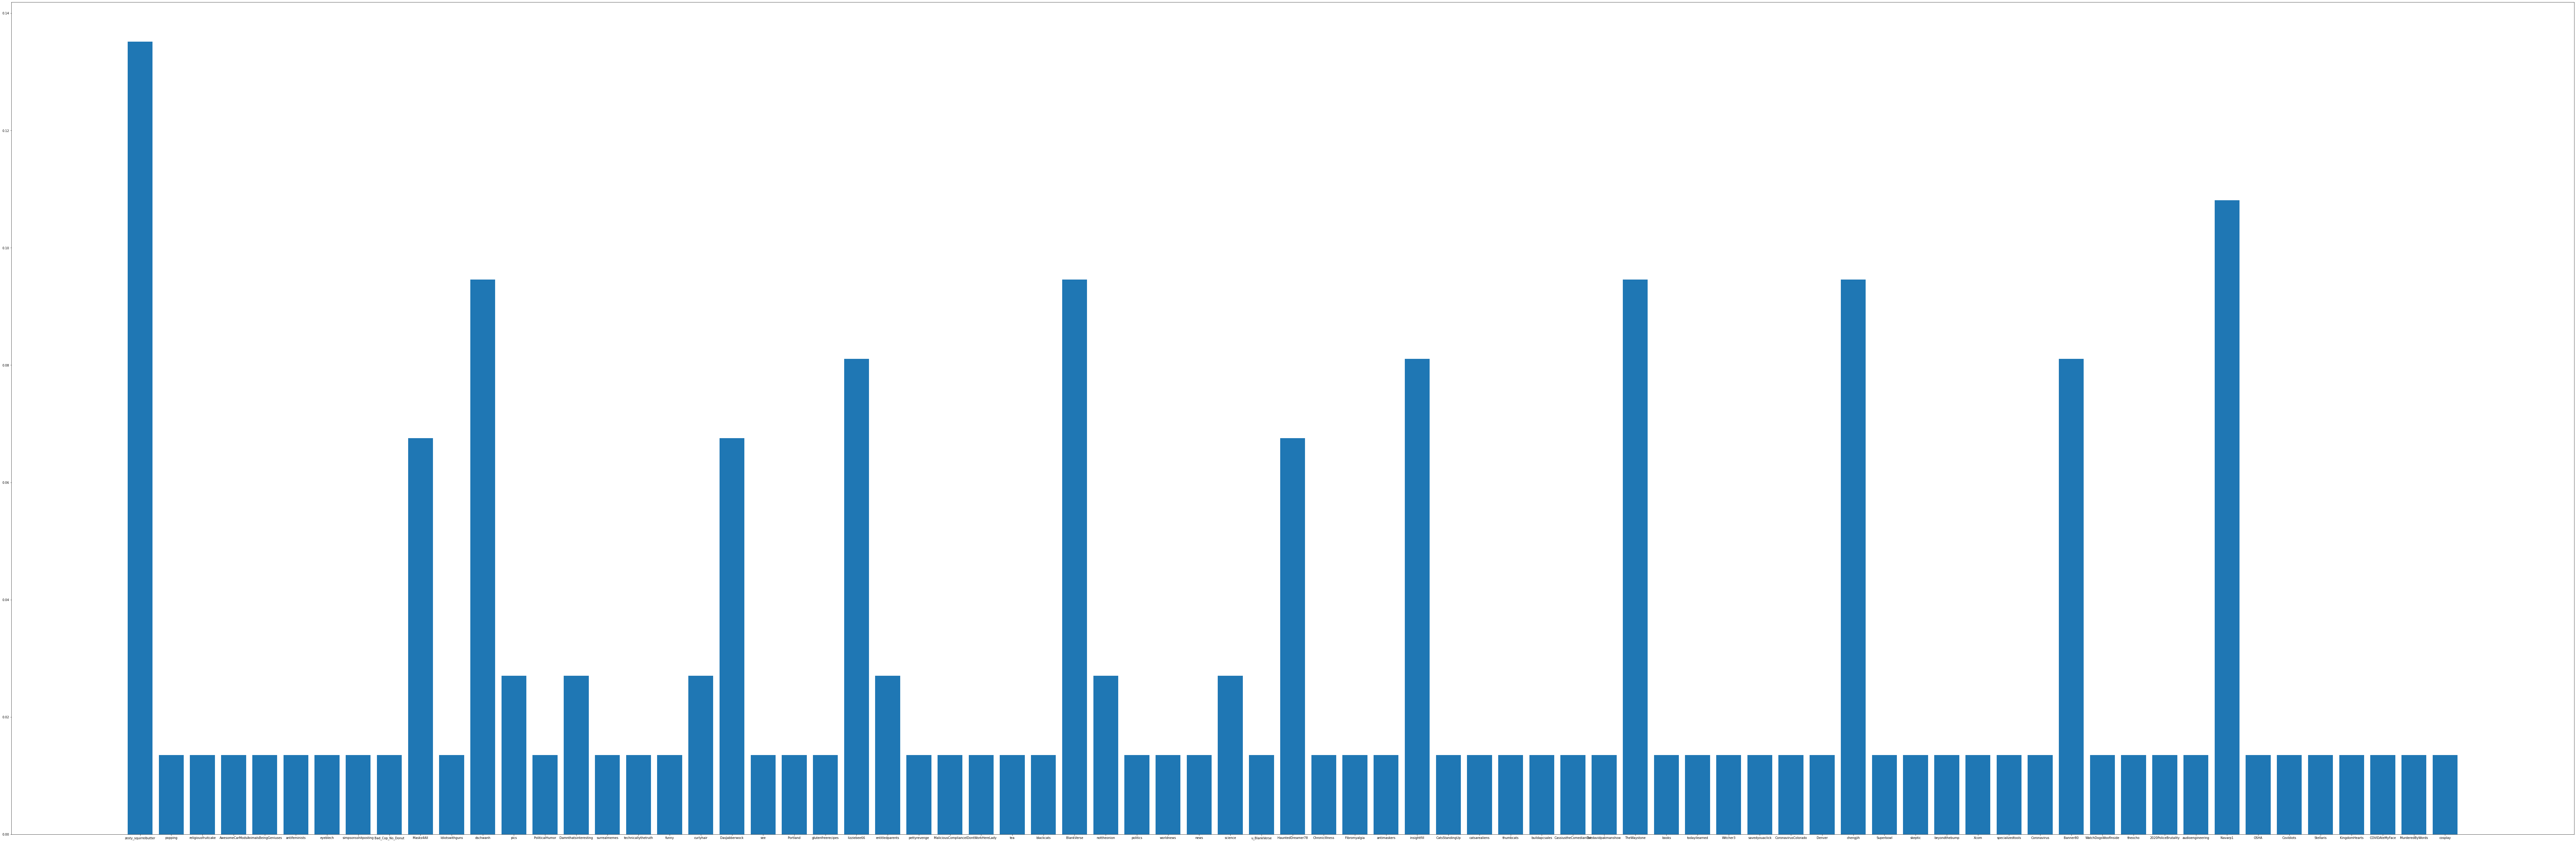

In [215]:
names, counts = zip(*a.items())
plt.figure(figsize=(150,50))
plt.bar(names, counts)

In [131]:
from datetime import datetime
time_format = "%d%b%Y %H:%M"
datetime.now().strftime(time_format)

'23Apr2022 11:21'

# Link Prediction

In [102]:
preds = nx.resource_allocation_index(g)
cnt=0
m=0
for u, v, p in preds:
    if p>m:
      m=p
      pair=(u,v)
    print(f"({u}, {v}) -> {p:.8f}")
    cnt=cnt+1
    if cnt==100:
      break
print(f"Max value : {pair} -> {m:.8f}")

(skeptic, eyeblech) -> 0.00000000
(skeptic, thumbcats) -> 0.00000000
(skeptic, see) -> 0.00000000
(skeptic, Portland) -> 0.00000000
(skeptic, CovIdiots) -> 0.00000000
(skeptic, DasJabberwock) -> 0.00000000
(skeptic, Denver) -> 0.00000000
(skeptic, audioengineering) -> 0.00000000
(skeptic, religiousfruitcake) -> 0.00000000
(skeptic, technicallythetruth) -> 0.00000000
(skeptic, AwesomeCarMods) -> 0.00000000
(skeptic, Navarp1) -> 0.00000000
(skeptic, surrealmemes) -> 0.00000000
(skeptic, politics) -> 0.00000000
(skeptic, curlyhair) -> 0.00000000
(skeptic, books) -> 0.00000000
(skeptic, Witcher3) -> 0.00000000
(skeptic, dschwanh) -> 0.00000000
(skeptic, Banner80) -> 0.00000000
(skeptic, popping) -> 0.00000000
(skeptic, antimaskers) -> 0.00000000
(skeptic, pics) -> 0.00000000
(skeptic, MaliciousCompliance) -> 0.00000000
(skeptic, pettyrevenge) -> 0.00000000
(skeptic, 2020PoliceBrutality) -> 0.00000000
(skeptic, cosplay) -> 0.00000000
(skeptic, lizziebee66) -> 0.00000000
(skeptic, blackcats)

# Jaccard Coefficient

In [104]:
preds = nx.jaccard_coefficient(g)
cnt=0
m=0
for u, v, p in preds:
    if p>m:
      m=p
      pair=(u,v)
    print(f"({u}, {v}) -> {p:.8f}")
    cnt=cnt+1
    if cnt==100:
      break
print(f"Max value : {pair} -> {m:.8f}")

(skeptic, eyeblech) -> 0.00000000
(skeptic, thumbcats) -> 0.00000000
(skeptic, see) -> 0.00000000
(skeptic, Portland) -> 0.00000000
(skeptic, CovIdiots) -> 0.00000000
(skeptic, DasJabberwock) -> 0.00000000
(skeptic, Denver) -> 0.00000000
(skeptic, audioengineering) -> 0.00000000
(skeptic, religiousfruitcake) -> 0.00000000
(skeptic, technicallythetruth) -> 0.00000000
(skeptic, AwesomeCarMods) -> 0.00000000
(skeptic, Navarp1) -> 0.00000000
(skeptic, surrealmemes) -> 0.00000000
(skeptic, politics) -> 0.00000000
(skeptic, curlyhair) -> 0.00000000
(skeptic, books) -> 0.00000000
(skeptic, Witcher3) -> 0.00000000
(skeptic, dschwanh) -> 0.00000000
(skeptic, Banner80) -> 0.00000000
(skeptic, popping) -> 0.00000000
(skeptic, antimaskers) -> 0.00000000
(skeptic, pics) -> 0.00000000
(skeptic, MaliciousCompliance) -> 0.00000000
(skeptic, pettyrevenge) -> 0.00000000
(skeptic, 2020PoliceBrutality) -> 0.00000000
(skeptic, cosplay) -> 0.00000000
(skeptic, lizziebee66) -> 0.00000000
(skeptic, blackcats)

## Adamic–Adar index

In [106]:
preds = nx.adamic_adar_index(g)
cnt=0
m=0
for u, v, p in preds:
    if p>m:
      m=p
      pair=(u,v)
    print(f"({u}, {v}) -> {p:.8f}")
    cnt=cnt+1
    if cnt==100:
      break
print(f"Max value : {pair} -> {m:.8f}")

(skeptic, eyeblech) -> 0.00000000
(skeptic, thumbcats) -> 0.00000000
(skeptic, see) -> 0.00000000
(skeptic, Portland) -> 0.00000000
(skeptic, CovIdiots) -> 0.00000000
(skeptic, DasJabberwock) -> 0.00000000
(skeptic, Denver) -> 0.00000000
(skeptic, audioengineering) -> 0.00000000
(skeptic, religiousfruitcake) -> 0.00000000
(skeptic, technicallythetruth) -> 0.00000000
(skeptic, AwesomeCarMods) -> 0.00000000
(skeptic, Navarp1) -> 0.00000000
(skeptic, surrealmemes) -> 0.00000000
(skeptic, politics) -> 0.00000000
(skeptic, curlyhair) -> 0.00000000
(skeptic, books) -> 0.00000000
(skeptic, Witcher3) -> 0.00000000
(skeptic, dschwanh) -> 0.00000000
(skeptic, Banner80) -> 0.00000000
(skeptic, popping) -> 0.00000000
(skeptic, antimaskers) -> 0.00000000
(skeptic, pics) -> 0.00000000
(skeptic, MaliciousCompliance) -> 0.00000000
(skeptic, pettyrevenge) -> 0.00000000
(skeptic, 2020PoliceBrutality) -> 0.00000000
(skeptic, cosplay) -> 0.00000000
(skeptic, lizziebee66) -> 0.00000000
(skeptic, blackcats)

## Preferential attachment 

In [108]:
preds = nx.preferential_attachment(g)
cnt=0
m=0
for u, v, p in preds:
    if p>m:
      m=p
      pair=(u,v)
    print(f"({u}, {v}) -> {p:.8f}")
    cnt=cnt+1
    if cnt==200:
      break
print(f"Max value : {pair} -> {m:.8f}")

(skeptic, eyeblech) -> 1.00000000
(skeptic, thumbcats) -> 1.00000000
(skeptic, see) -> 1.00000000
(skeptic, Portland) -> 1.00000000
(skeptic, CovIdiots) -> 1.00000000
(skeptic, DasJabberwock) -> 5.00000000
(skeptic, Denver) -> 1.00000000
(skeptic, audioengineering) -> 1.00000000
(skeptic, religiousfruitcake) -> 1.00000000
(skeptic, technicallythetruth) -> 1.00000000
(skeptic, AwesomeCarMods) -> 1.00000000
(skeptic, Navarp1) -> 8.00000000
(skeptic, surrealmemes) -> 1.00000000
(skeptic, politics) -> 1.00000000
(skeptic, curlyhair) -> 2.00000000
(skeptic, books) -> 1.00000000
(skeptic, Witcher3) -> 1.00000000
(skeptic, dschwanh) -> 7.00000000
(skeptic, Banner80) -> 6.00000000
(skeptic, popping) -> 1.00000000
(skeptic, antimaskers) -> 1.00000000
(skeptic, pics) -> 2.00000000
(skeptic, MaliciousCompliance) -> 1.00000000
(skeptic, pettyrevenge) -> 1.00000000
(skeptic, 2020PoliceBrutality) -> 1.00000000
(skeptic, cosplay) -> 1.00000000
(skeptic, lizziebee66) -> 6.00000000
(skeptic, blackcats)

## Louvain Community Detection 

In [140]:
!pip install community

  Created wheel for community: filename=community-1.0.0b1-py3-none-any.whl size=2153 sha256=2e72e406c68eba595f3559299b1da78ef9b6193f281fd50bd440efdeb6860702
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\82\c4\04\d1a2e10b418aae6a1f7135eb20be8f2fb447d967f02f6afb3d
Successfully built community


In [142]:
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms.community.centrality import girvan_newman

# Girvan Newman

In [155]:
import networkx as nx
import matplotlib.pyplot as plt

%matplotlib inline

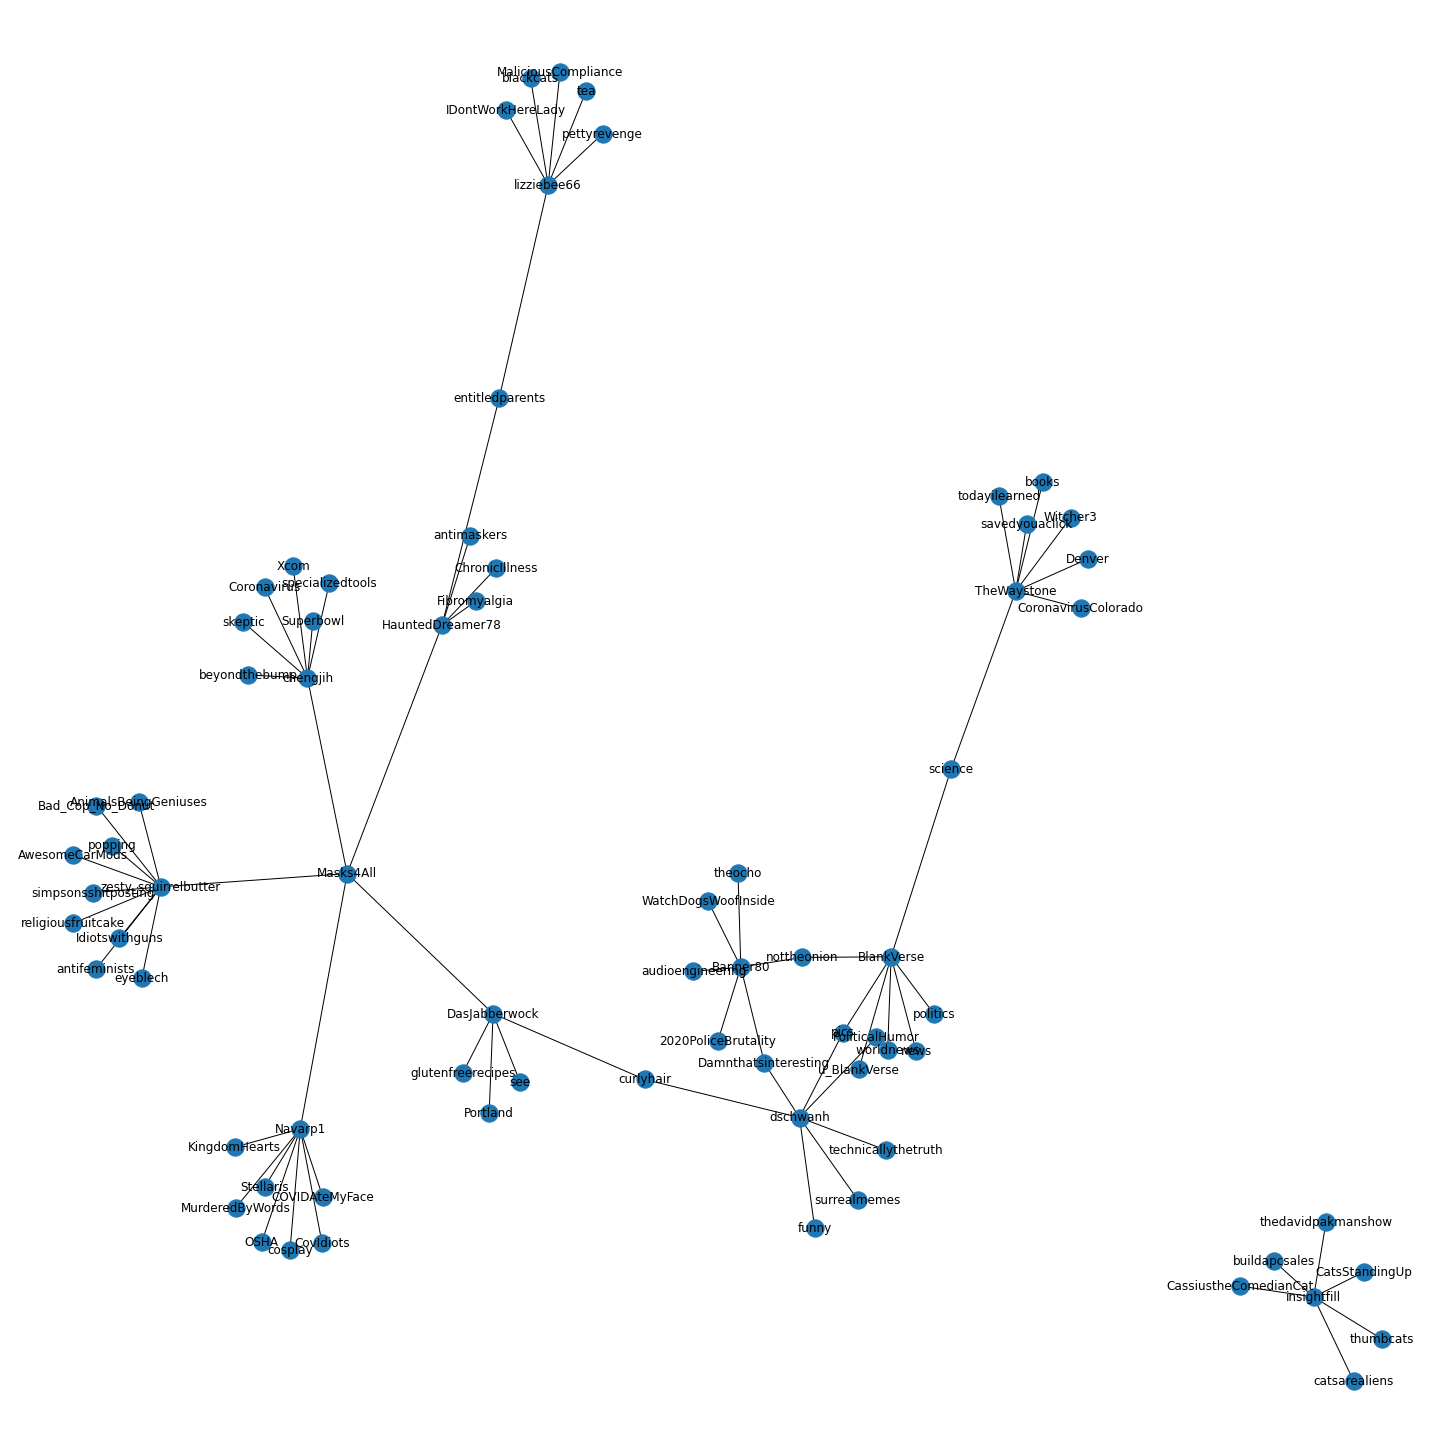

In [159]:
# load the graph
plt.figure(figsize=(20, 20))
g = nx.from_pandas_edgelist(n_df, source='author', target='subreddit') 
# visualize the graph
nx.draw(g, with_labels = True)


In [160]:
def edge_to_remove(graph):
  G_dict = nx.edge_betweenness_centrality(g)
  edge = ()

  # extract the edge with highest edge betweenness centrality score
  for key, value in sorted(G_dict.items(), key=lambda item: item[1], reverse = True):
      edge = key
      break

  return edge

In [161]:
def girvan_newman(graph):
	# find number of connected components
	sg = nx.connected_components(graph)
	sg_count = nx.number_connected_components(graph)

	while(sg_count == 1):
		graph.remove_edge(edge_to_remove(graph)[0], edge_to_remove(graph)[1])
		sg = nx.connected_components(graph)
		sg_count = nx.number_connected_components(graph)

	return sg

In [163]:
# find communities in the graph
c = girvan_newman(g.copy())

# find the nodes forming the communities
node_groups = []

for i in c:
  node_groups.append(list(i))
node_groups

[['skeptic',
  'science',
  'eyeblech',
  'entitledparents',
  'Portland',
  'see',
  'OSHA',
  'Masks4All',
  'CovIdiots',
  'DasJabberwock',
  'Denver',
  'todayilearned',
  'AnimalsBeingGeniuses',
  'KingdomHearts',
  'theocho',
  'audioengineering',
  'religiousfruitcake',
  'WatchDogsWoofInside',
  'technicallythetruth',
  'Xcom',
  'chengjih',
  'glutenfreerecipes',
  'AwesomeCarMods',
  'simpsonsshitposting',
  'worldnews',
  'Navarp1',
  'IDontWorkHereLady',
  'COVIDAteMyFace',
  'surrealmemes',
  'curlyhair',
  'nottheonion',
  'beyondthebump',
  'politics',
  'books',
  'Witcher3',
  'dschwanh',
  'Banner80',
  'popping',
  'CoronavirusColorado',
  'Fibromyalgia',
  'antimaskers',
  'pics',
  'antifeminists',
  'MaliciousCompliance',
  'MurderedByWords',
  'pettyrevenge',
  '2020PoliceBrutality',
  'cosplay',
  'HauntedDreamer78',
  'lizziebee66',
  'BlankVerse',
  'blackcats',
  'Stellaris',
  'Coronavirus',
  'ChronicIllness',
  'Idiotswithguns',
  'PoliticalHumor',
  'u_Bl

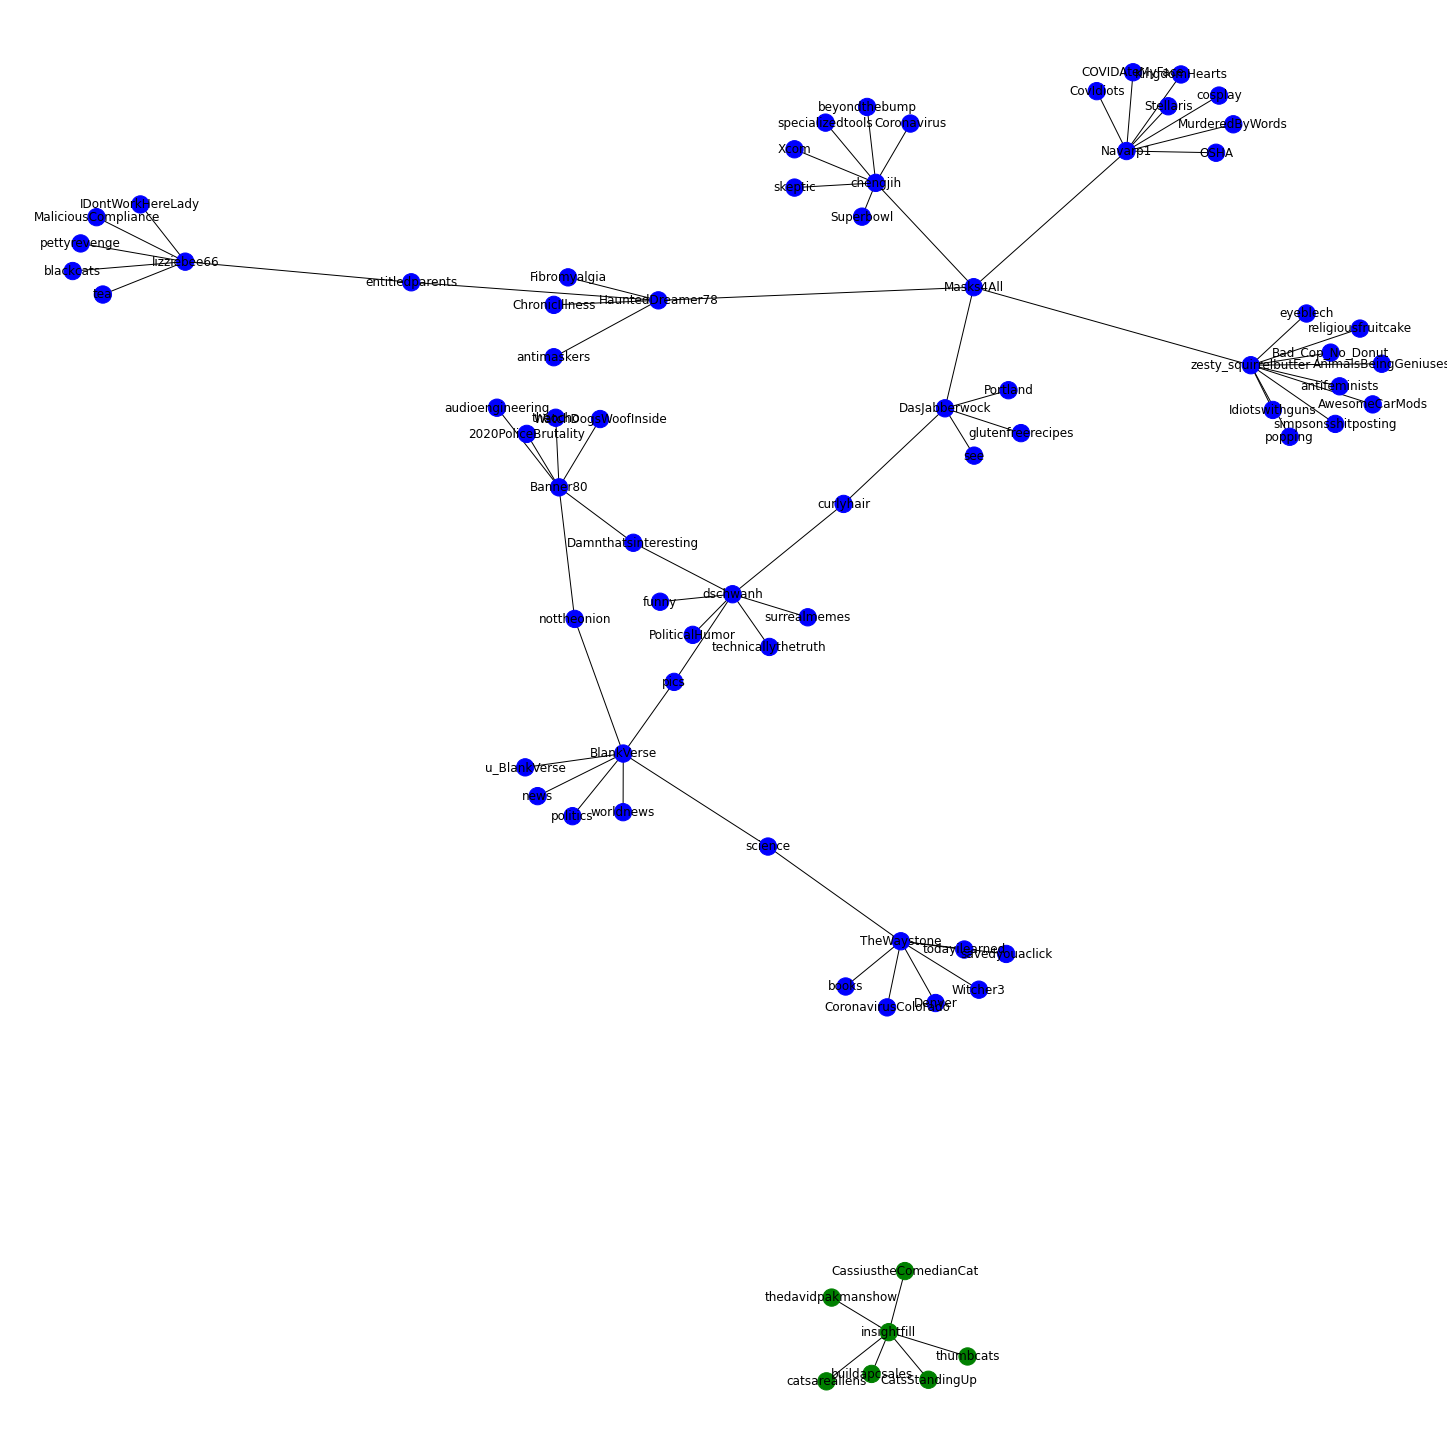

In [165]:
# plot the communities
plt.figure(figsize=(20, 20))
color_map = []
for node in g:
    if node in node_groups[0]:
        color_map.append('blue')
    else: 
        color_map.append('green')  

nx.draw(g, node_color=color_map, with_labels=True)
plt.show()

# Subreddit 3

In [77]:
import matplotlib.pyplot as plt

In [78]:
marvel_df = get_posts('masks4all', 100) # This is where you can define any subreddit and 
                                            # run all the cells to get the network graph

In [79]:
marvel_df.author.nunique() # Out of 500, 373(new_NUMBER_SANKU) are unique 

80

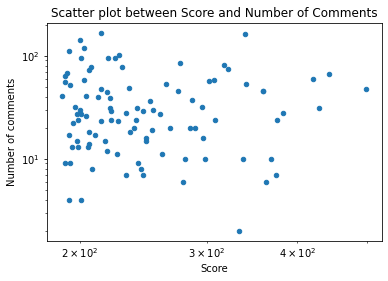

In [80]:
# See the relationship between comments and upvotes 
ax = marvel_df.plot('score', 'num_comments', kind = 'scatter',logx=True, logy=True, title='Scatter plot between Score and Number of Comments')
ax.set(xlabel="Score", ylabel="Number of comments")
plt.savefig("ScatterPlot",dpi=150, bbox_inches='tight',pad_inches=0.5)

In [81]:
repeating = marvel_df[marvel_df.duplicated(['author'], keep = False)] # Only take users who posted more than once

In [82]:
repeating = repeating[repeating.author != 'None'] # Get rid of deleted users

In [83]:
repeating.author.nunique() # Out of 500 posts, this is the amount of people who posted more than once 

11

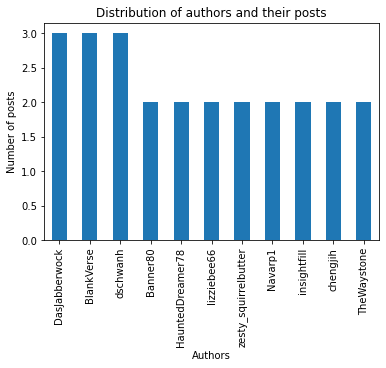

In [84]:
# See the distrubution of authors and their posts
ax = repeating.author.value_counts().plot(kind='bar',title='Distribution of authors and their posts') 
ax.set(xlabel="Authors", ylabel="Number of posts")
plt.savefig("Bargraph",dpi=150, bbox_inches='tight',pad_inches=0.5)

In [85]:
# Compiling a list of authors that appeared more than once on subreddit's top of all times 
# (Used for network graph and for get_user_posts function)
u_authors = list(repeating.author.unique()) 

In [86]:
authors_df =  pd.DataFrame() # Makes an empty dataframe
authors_df = authors_df.fillna(0)
for u in u_authors: # Loops through every "influencer" user and gets 10 top posts per user
    c = get_user_posts(u, 10)
    authors_df = pd.concat([authors_df, c]) 

In [87]:
authors_df = authors_df.rename(index=str, #renaming column names 
                               columns={0: "id", 1: "score", 2: "author", 3: "num_comments", 4: "subreddit"})

In [88]:
authors_df.head(10) # Dataframe of other subreddits where authors posted 

id  score                author  num_comments             subreddit
0  lg5h4o   5405  zesty_squirrelbutter           337               popping
1  htupup   2695  zesty_squirrelbutter           127    religiousfruitcake
2  kgou74   2150  zesty_squirrelbutter            71        AwesomeCarMods
3  hvx3h1   1408  zesty_squirrelbutter            19  AnimalsBeingGeniuses
4  l7gfjx   1001  zesty_squirrelbutter           132         antifeminists
5  itq0qf    903  zesty_squirrelbutter            52              eyeblech
6  ht0p0c    578  zesty_squirrelbutter           119   simpsonsshitposting
7  ht8gwo    438  zesty_squirrelbutter            12      Bad_Cop_No_Donut
8  i367pw    302  zesty_squirrelbutter            57             Masks4All
9  ikwhrl    230  zesty_squirrelbutter             4        Idiotswithguns

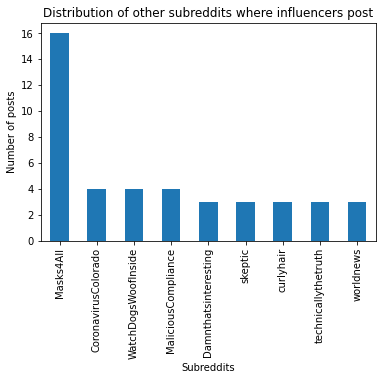

In [89]:
counts = authors_df['subreddit'].value_counts() 
# Only plot the subreddits that appear more than twice
ax = authors_df[authors_df['subreddit'].isin(counts[counts > 2].index)].subreddit.value_counts().plot(kind='bar',title='Distribution of other subreddits where influencers post') 
ax.set(xlabel="Subreddits", ylabel="Number of posts")
plt.savefig("BargraphSubreddits",dpi=150, bbox_inches='tight',pad_inches=0.5)

# Network Analysis

## Initial approach

In [90]:
n_df = authors_df[['author', 'subreddit']] # Create a dataframe for network graph purposes 
n_df.head()

author             subreddit
0  zesty_squirrelbutter               popping
1  zesty_squirrelbutter    religiousfruitcake
2  zesty_squirrelbutter        AwesomeCarMods
3  zesty_squirrelbutter  AnimalsBeingGeniuses
4  zesty_squirrelbutter         antifeminists

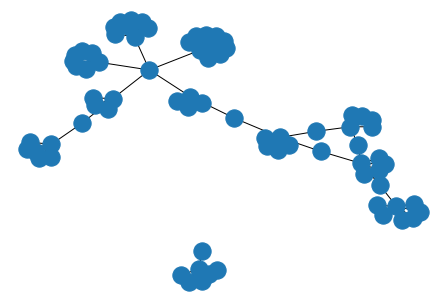

In [91]:
g = nx.from_pandas_edgelist(n_df, source='author', target='subreddit') # Initial ugly approach, decided to keep it
nx.draw(g)

## Final Approach

In [92]:
subs = list(n_df.subreddit.unique()) # Make list of unique subreddits to use in network graph 

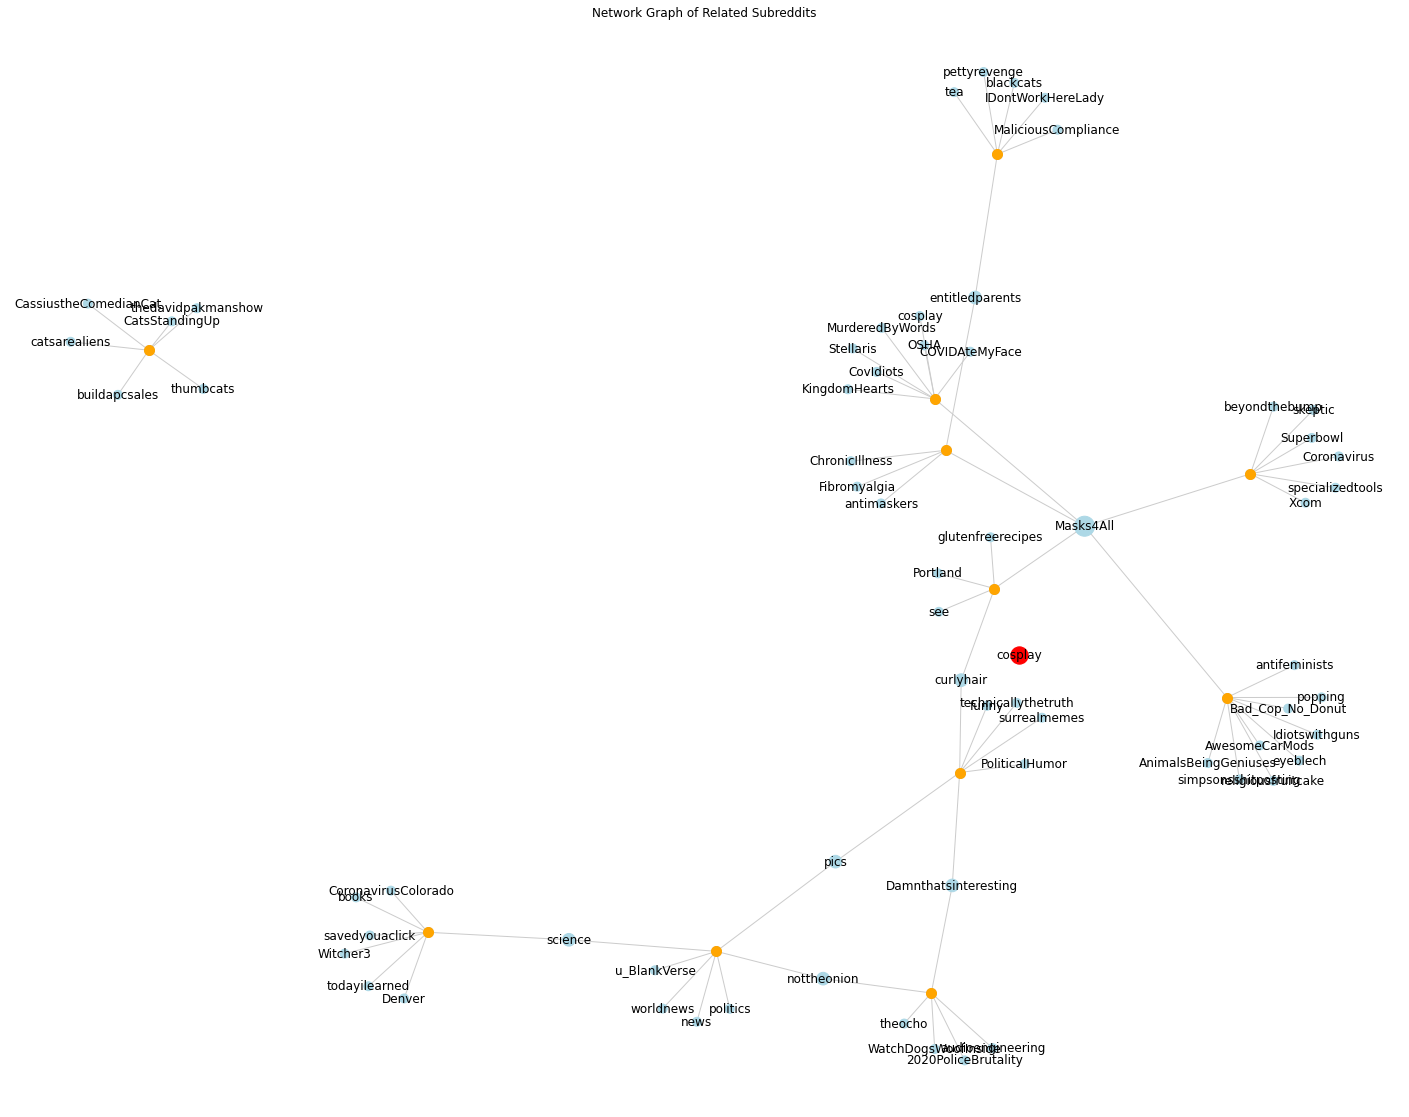

In [191]:
plt.figure(figsize=(25, 20))

# Create the graph from the dataframe
g = nx.from_pandas_edgelist(n_df, source='author', target='subreddit') 

# Create a layout for nodes 
layout = nx.spring_layout(g,iterations=50,scale=2)
pos=nx.spring_layout(g)

# Draw the parts we want, edges thin and grey
# Influencers appear small and grey
# Subreddits appear in blue and sized according to their respective number of connections.
# Labels for subreddits ONLY
# People who have more connections are highlighted in color 

# Go through every subbreddit, ask the graph how many connections it has. 
# Multiply that by 80 to get the circle size
sub_size = [g.degree(sub) * 80 for sub in subs]
nx.draw_networkx_nodes(g, 
                       layout, 
                       nodelist=subs, 
                       node_size=sub_size, # a LIST of sizes, based on g.degree
                       node_color='lightblue')

# Draw all the entities 
nx.draw_networkx_nodes(g, layout, nodelist=u_authors, node_color='#cccccc', node_size=100)

# Draw highly connected influencers 
popular_people = [person for person in u_authors if g.degree(person) > 1]
nx.draw_networkx_nodes(g, layout, nodelist=popular_people, node_color='orange', node_size=100)

nx.draw_networkx_edges(g, layout, width=1, edge_color="#cccccc")

node_labels = dict(zip(subs, subs)) #labels for subs
nx.draw_networkx_labels(g, layout, labels=node_labels)
nx.draw_networkx(g.subgraph('cosplay'),pos=pos,node_color='red')

# No axis needed
plt.axis('off')
plt.title("Network Graph of Related Subreddits")
plt.savefig("NetworkGraph", bbox_inches='tight',pad_inches=0.8)
plt.show()

In [94]:
g.degree('Masks4All') # To check the number of out-degrees for a subreddit, if interested 

5

In [115]:
from itertools import islice

def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

In [190]:
a=nx.degree_centrality(g)
print(a)

{'zesty_squirrelbutter': 0.13513513513513514, 'popping': 0.013513513513513514, 'religiousfruitcake': 0.013513513513513514, 'AwesomeCarMods': 0.013513513513513514, 'AnimalsBeingGeniuses': 0.013513513513513514, 'antifeminists': 0.013513513513513514, 'eyeblech': 0.013513513513513514, 'simpsonsshitposting': 0.013513513513513514, 'Bad_Cop_No_Donut': 0.013513513513513514, 'Masks4All': 0.06756756756756757, 'Idiotswithguns': 0.013513513513513514, 'dschwanh': 0.0945945945945946, 'pics': 0.02702702702702703, 'PoliticalHumor': 0.013513513513513514, 'Damnthatsinteresting': 0.02702702702702703, 'surrealmemes': 0.013513513513513514, 'technicallythetruth': 0.013513513513513514, 'funny': 0.013513513513513514, 'curlyhair': 0.02702702702702703, 'DasJabberwock': 0.06756756756756757, 'see': 0.013513513513513514, 'Portland': 0.013513513513513514, 'glutenfreerecipes': 0.013513513513513514, 'lizziebee66': 0.08108108108108109, 'entitledparents': 0.02702702702702703, 'pettyrevenge': 0.013513513513513514, 'Mali

In [117]:
b=nx.closeness_centrality(g)
print(b)

{'zesty_squirrelbutter': 0.2106325075075075, 'popping': 0.1713620400061078, 'religiousfruitcake': 0.1713620400061078, 'AwesomeCarMods': 0.1713620400061078, 'AnimalsBeingGeniuses': 0.1713620400061078, 'antifeminists': 0.1713620400061078, 'eyeblech': 0.1713620400061078, 'simpsonsshitposting': 0.1713620400061078, 'Bad_Cop_No_Donut': 0.1713620400061078, 'Masks4All': 0.252759009009009, 'Idiotswithguns': 0.1713620400061078, 'dschwanh': 0.21979044261652955, 'pics': 0.19319159924255466, 'PoliticalHumor': 0.17737474316421684, 'Damnthatsinteresting': 0.18382473382473383, 'surrealmemes': 0.17737474316421684, 'technicallythetruth': 0.17737474316421684, 'funny': 0.17737474316421684, 'curlyhair': 0.2333160083160083, 'DasJabberwock': 0.24659415513074048, 'see': 0.19443000693000692, 'Portland': 0.19443000693000692, 'glutenfreerecipes': 0.19443000693000692, 'lizziebee66': 0.15318727818727818, 'entitledparents': 0.17841812400635929, 'pettyrevenge': 0.1313033813033813, 'MaliciousCompliance': 0.1313033813

In [97]:
c=nx.betweenness_centrality(g)
print(c)

{'zesty_squirrelbutter': 0.20659015179563125, 'popping': 0.0, 'religiousfruitcake': 0.0, 'AwesomeCarMods': 0.0, 'AnimalsBeingGeniuses': 0.0, 'antifeminists': 0.0, 'eyeblech': 0.0, 'simpsonsshitposting': 0.0, 'Bad_Cop_No_Donut': 0.0, 'Masks4All': 0.5912624953720844, 'Idiotswithguns': 0.0, 'dschwanh': 0.4257682339874121, 'pics': 0.23731951129211404, 'PoliticalHumor': 0.0, 'Damnthatsinteresting': 0.09663087745279526, 'surrealmemes': 0.0, 'technicallythetruth': 0.0, 'funny': 0.0, 'curlyhair': 0.3946686412439837, 'DasJabberwock': 0.4420584968530174, 'see': 0.0, 'Portland': 0.0, 'glutenfreerecipes': 0.0, 'lizziebee66': 0.11847463902258423, 'entitledparents': 0.13550536838208072, 'pettyrevenge': 0.0, 'MaliciousCompliance': 0.0, 'IDontWorkHereLady': 0.0, 'tea': 0.0, 'blackcats': 0.0, 'BlankVerse': 0.2684191040355424, 'nottheonion': 0.027397260273972605, 'politics': 0.0, 'worldnews': 0.0, 'news': 0.0, 'science': 0.1554979637171418, 'u_BlankVerse': 0.0, 'HauntedDreamer78': 0.21991854868567198, '

In [98]:
d=nx.edge_betweenness_centrality(g)
print(d)

{('zesty_squirrelbutter', 'popping'): 0.024144144144144144, ('zesty_squirrelbutter', 'religiousfruitcake'): 0.024144144144144144, ('zesty_squirrelbutter', 'AwesomeCarMods'): 0.024144144144144144, ('zesty_squirrelbutter', 'AnimalsBeingGeniuses'): 0.024144144144144144, ('zesty_squirrelbutter', 'antifeminists'): 0.024144144144144144, ('zesty_squirrelbutter', 'eyeblech'): 0.024144144144144144, ('zesty_squirrelbutter', 'simpsonsshitposting'): 0.024144144144144144, ('zesty_squirrelbutter', 'Bad_Cop_No_Donut'): 0.024144144144144144, ('zesty_squirrelbutter', 'Masks4All'): 0.209009009009009, ('zesty_squirrelbutter', 'Idiotswithguns'): 0.024144144144144144, ('Masks4All', 'DasJabberwock'): 0.41333333333333333, ('Masks4All', 'HauntedDreamer78'): 0.22594594594594594, ('Masks4All', 'chengjih'): 0.15387387387387388, ('Masks4All', 'Navarp1'): 0.17297297297297298, ('dschwanh', 'pics'): 0.2491891891891892, ('dschwanh', 'PoliticalHumor'): 0.024144144144144144, ('dschwanh', 'Damnthatsinteresting'): 0.1136

In [99]:
e=nx.voterank(g)
print(e)

['zesty_squirrelbutter', 'Navarp1', 'dschwanh', 'TheWaystone', 'lizziebee66', 'insightfill', 'chengjih', 'BlankVerse', 'Banner80', 'DasJabberwock', 'HauntedDreamer78']


In [100]:
f=nx.pagerank(g)
print(f)

{'zesty_squirrelbutter': 0.06338748915191594, 'popping': 0.007387532401405708, 'religiousfruitcake': 0.007387532401405708, 'AwesomeCarMods': 0.007387532401405708, 'AnimalsBeingGeniuses': 0.007387532401405708, 'antifeminists': 0.007387532401405708, 'eyeblech': 0.007387532401405708, 'simpsonsshitposting': 0.007387532401405708, 'Bad_Cop_No_Donut': 0.007387532401405708, 'Masks4All': 0.028640152301729845, 'Idiotswithguns': 0.007387532401405708, 'dschwanh': 0.04149745607105626, 'pics': 0.012126998026056476, 'PoliticalHumor': 0.007038588446089856, 'Damnthatsinteresting': 0.012308968081862026, 'surrealmemes': 0.007038588446089856, 'technicallythetruth': 0.007038588446089856, 'funny': 0.007038588446089856, 'curlyhair': 0.012184119871833005, 'DasJabberwock': 0.030270165218575926, 'see': 0.007145531425743149, 'Portland': 0.007145531425743149, 'glutenfreerecipes': 0.007145531425743149, 'lizziebee66': 0.04020687490570032, 'entitledparents': 0.012937144530190167, 'pettyrevenge': 0.00769557510220926,

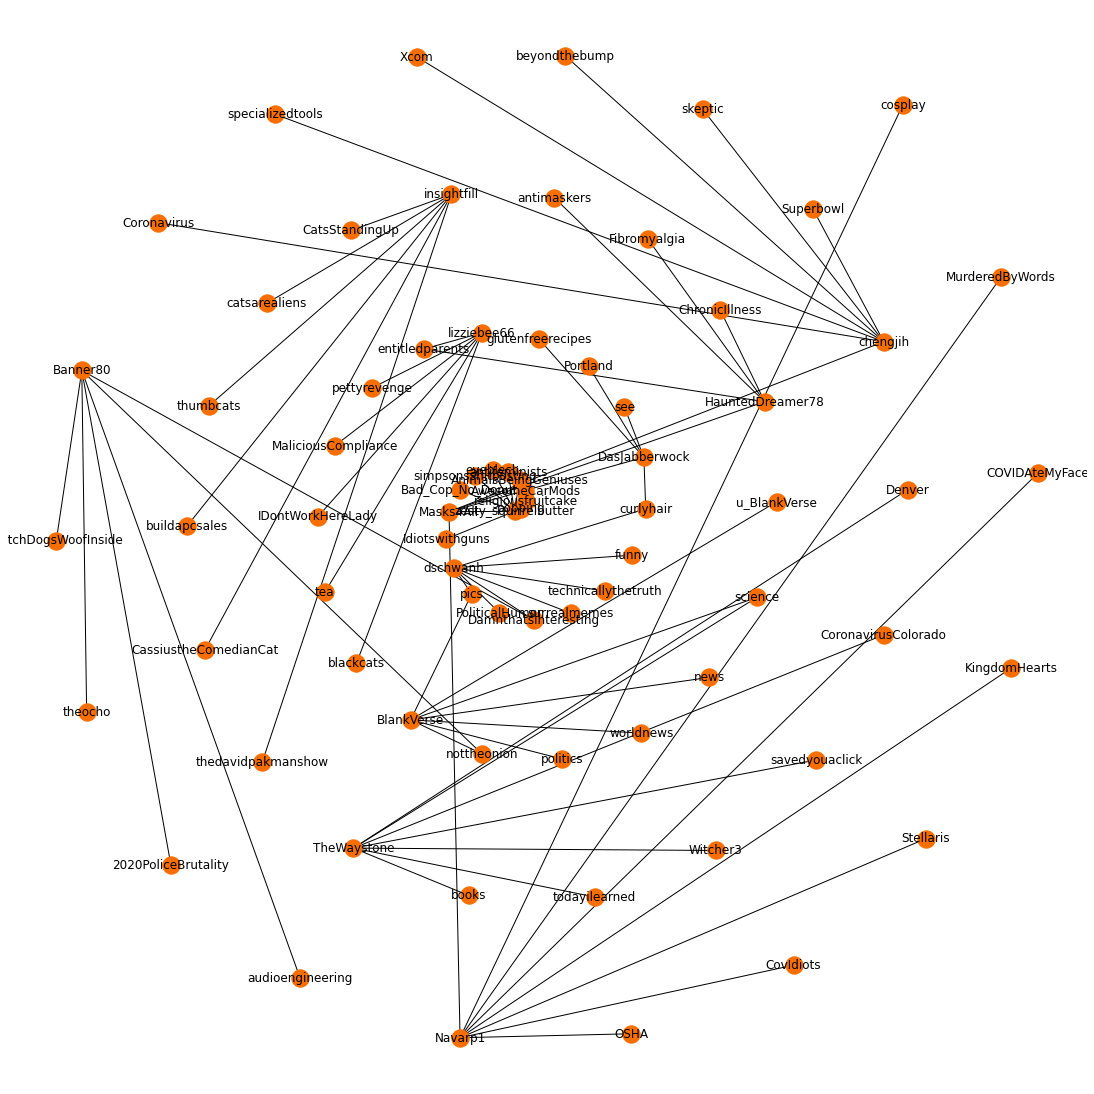

In [214]:
pos = nx.spiral_layout(g)
plt.figure(figsize=(15,15))
nx.draw(g, pos, with_labels = True, node_color="#f86e00")
plt.show()

<BarContainer object of 75 artists>

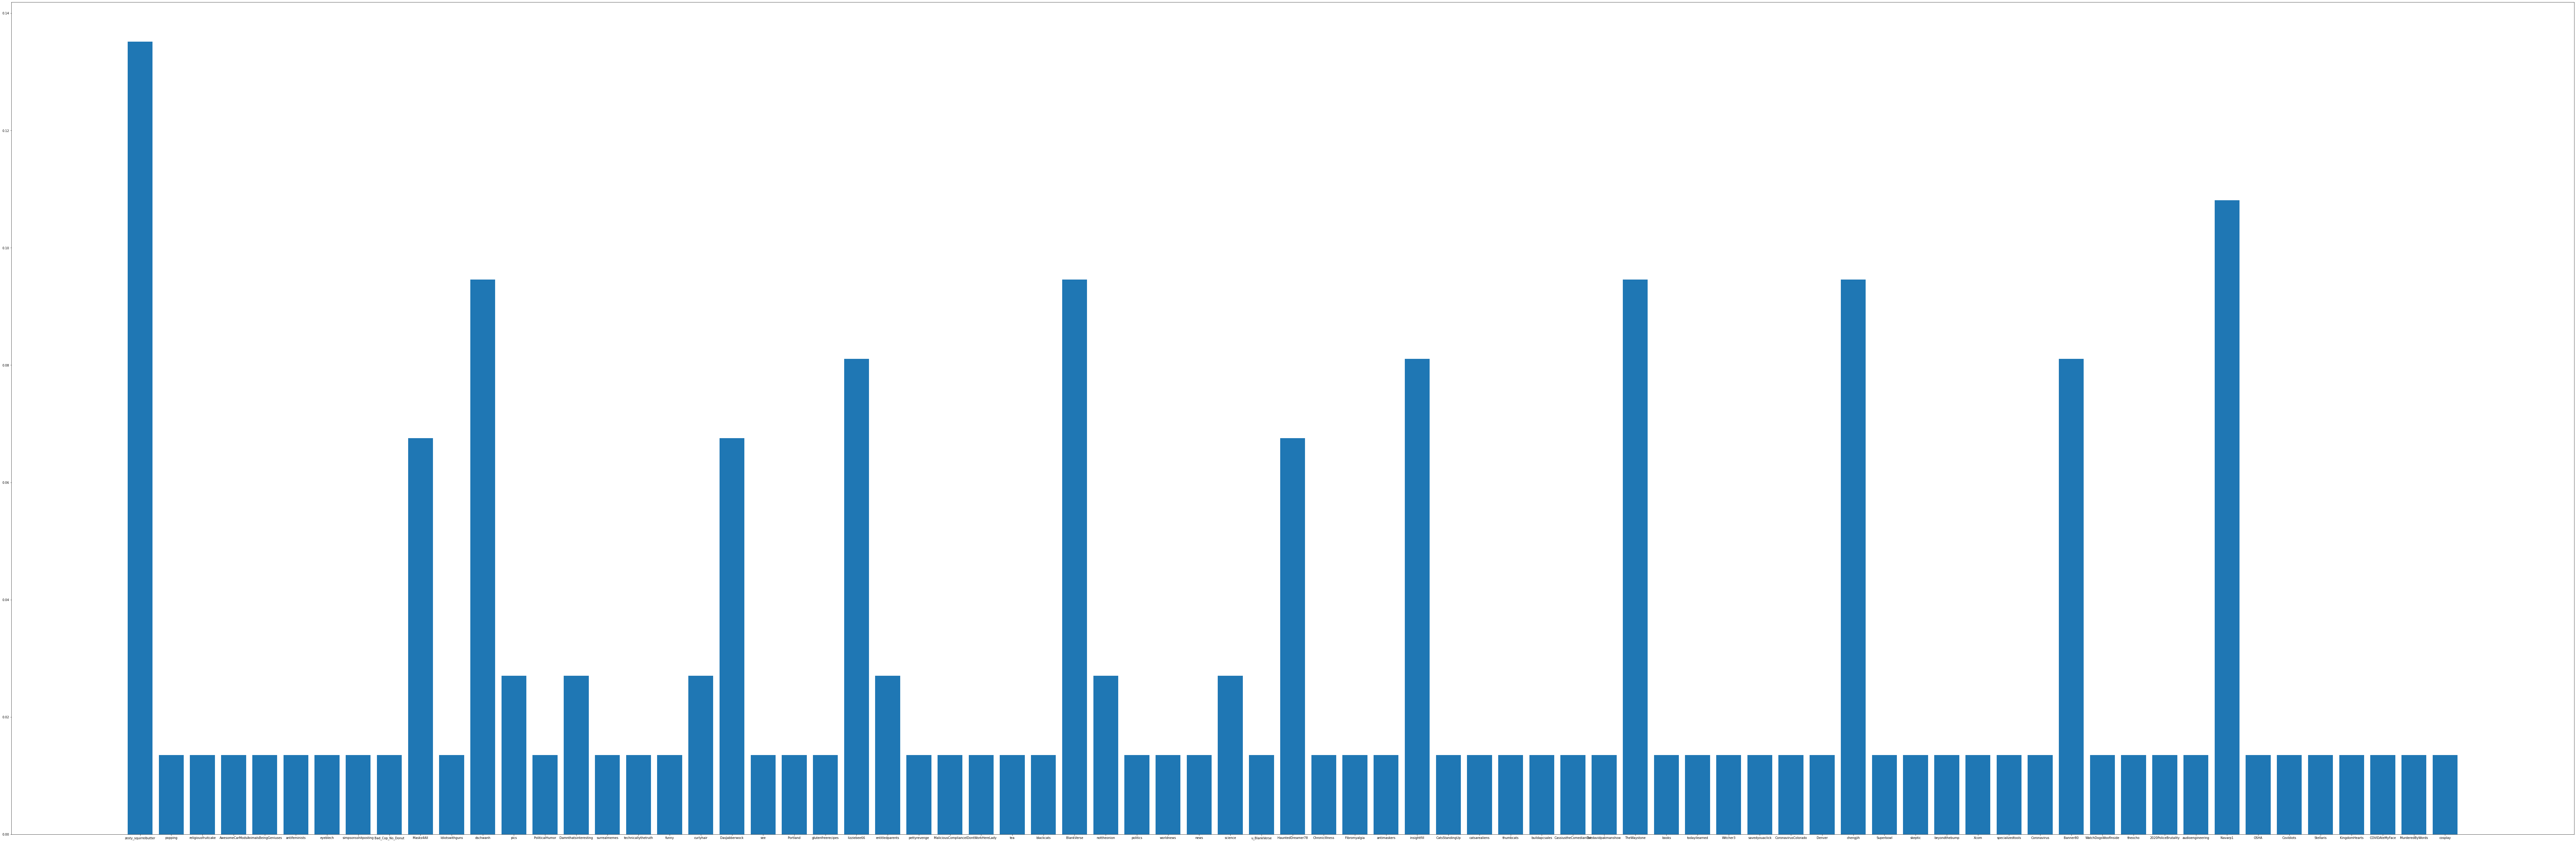

In [215]:
names, counts = zip(*a.items())
plt.figure(figsize=(150,50))
plt.bar(names, counts)

In [131]:
from datetime import datetime
time_format = "%d%b%Y %H:%M"
datetime.now().strftime(time_format)

'23Apr2022 11:21'

# Link Prediction

In [102]:
preds = nx.resource_allocation_index(g)
cnt=0
m=0
for u, v, p in preds:
    if p>m:
      m=p
      pair=(u,v)
    print(f"({u}, {v}) -> {p:.8f}")
    cnt=cnt+1
    if cnt==100:
      break
print(f"Max value : {pair} -> {m:.8f}")

(skeptic, eyeblech) -> 0.00000000
(skeptic, thumbcats) -> 0.00000000
(skeptic, see) -> 0.00000000
(skeptic, Portland) -> 0.00000000
(skeptic, CovIdiots) -> 0.00000000
(skeptic, DasJabberwock) -> 0.00000000
(skeptic, Denver) -> 0.00000000
(skeptic, audioengineering) -> 0.00000000
(skeptic, religiousfruitcake) -> 0.00000000
(skeptic, technicallythetruth) -> 0.00000000
(skeptic, AwesomeCarMods) -> 0.00000000
(skeptic, Navarp1) -> 0.00000000
(skeptic, surrealmemes) -> 0.00000000
(skeptic, politics) -> 0.00000000
(skeptic, curlyhair) -> 0.00000000
(skeptic, books) -> 0.00000000
(skeptic, Witcher3) -> 0.00000000
(skeptic, dschwanh) -> 0.00000000
(skeptic, Banner80) -> 0.00000000
(skeptic, popping) -> 0.00000000
(skeptic, antimaskers) -> 0.00000000
(skeptic, pics) -> 0.00000000
(skeptic, MaliciousCompliance) -> 0.00000000
(skeptic, pettyrevenge) -> 0.00000000
(skeptic, 2020PoliceBrutality) -> 0.00000000
(skeptic, cosplay) -> 0.00000000
(skeptic, lizziebee66) -> 0.00000000
(skeptic, blackcats)

# Jaccard Coefficient

In [104]:
preds = nx.jaccard_coefficient(g)
cnt=0
m=0
for u, v, p in preds:
    if p>m:
      m=p
      pair=(u,v)
    print(f"({u}, {v}) -> {p:.8f}")
    cnt=cnt+1
    if cnt==100:
      break
print(f"Max value : {pair} -> {m:.8f}")

(skeptic, eyeblech) -> 0.00000000
(skeptic, thumbcats) -> 0.00000000
(skeptic, see) -> 0.00000000
(skeptic, Portland) -> 0.00000000
(skeptic, CovIdiots) -> 0.00000000
(skeptic, DasJabberwock) -> 0.00000000
(skeptic, Denver) -> 0.00000000
(skeptic, audioengineering) -> 0.00000000
(skeptic, religiousfruitcake) -> 0.00000000
(skeptic, technicallythetruth) -> 0.00000000
(skeptic, AwesomeCarMods) -> 0.00000000
(skeptic, Navarp1) -> 0.00000000
(skeptic, surrealmemes) -> 0.00000000
(skeptic, politics) -> 0.00000000
(skeptic, curlyhair) -> 0.00000000
(skeptic, books) -> 0.00000000
(skeptic, Witcher3) -> 0.00000000
(skeptic, dschwanh) -> 0.00000000
(skeptic, Banner80) -> 0.00000000
(skeptic, popping) -> 0.00000000
(skeptic, antimaskers) -> 0.00000000
(skeptic, pics) -> 0.00000000
(skeptic, MaliciousCompliance) -> 0.00000000
(skeptic, pettyrevenge) -> 0.00000000
(skeptic, 2020PoliceBrutality) -> 0.00000000
(skeptic, cosplay) -> 0.00000000
(skeptic, lizziebee66) -> 0.00000000
(skeptic, blackcats)

## Adamic–Adar index

In [106]:
preds = nx.adamic_adar_index(g)
cnt=0
m=0
for u, v, p in preds:
    if p>m:
      m=p
      pair=(u,v)
    print(f"({u}, {v}) -> {p:.8f}")
    cnt=cnt+1
    if cnt==100:
      break
print(f"Max value : {pair} -> {m:.8f}")

(skeptic, eyeblech) -> 0.00000000
(skeptic, thumbcats) -> 0.00000000
(skeptic, see) -> 0.00000000
(skeptic, Portland) -> 0.00000000
(skeptic, CovIdiots) -> 0.00000000
(skeptic, DasJabberwock) -> 0.00000000
(skeptic, Denver) -> 0.00000000
(skeptic, audioengineering) -> 0.00000000
(skeptic, religiousfruitcake) -> 0.00000000
(skeptic, technicallythetruth) -> 0.00000000
(skeptic, AwesomeCarMods) -> 0.00000000
(skeptic, Navarp1) -> 0.00000000
(skeptic, surrealmemes) -> 0.00000000
(skeptic, politics) -> 0.00000000
(skeptic, curlyhair) -> 0.00000000
(skeptic, books) -> 0.00000000
(skeptic, Witcher3) -> 0.00000000
(skeptic, dschwanh) -> 0.00000000
(skeptic, Banner80) -> 0.00000000
(skeptic, popping) -> 0.00000000
(skeptic, antimaskers) -> 0.00000000
(skeptic, pics) -> 0.00000000
(skeptic, MaliciousCompliance) -> 0.00000000
(skeptic, pettyrevenge) -> 0.00000000
(skeptic, 2020PoliceBrutality) -> 0.00000000
(skeptic, cosplay) -> 0.00000000
(skeptic, lizziebee66) -> 0.00000000
(skeptic, blackcats)

## Preferential attachment 

In [108]:
preds = nx.preferential_attachment(g)
cnt=0
m=0
for u, v, p in preds:
    if p>m:
      m=p
      pair=(u,v)
    print(f"({u}, {v}) -> {p:.8f}")
    cnt=cnt+1
    if cnt==200:
      break
print(f"Max value : {pair} -> {m:.8f}")

(skeptic, eyeblech) -> 1.00000000
(skeptic, thumbcats) -> 1.00000000
(skeptic, see) -> 1.00000000
(skeptic, Portland) -> 1.00000000
(skeptic, CovIdiots) -> 1.00000000
(skeptic, DasJabberwock) -> 5.00000000
(skeptic, Denver) -> 1.00000000
(skeptic, audioengineering) -> 1.00000000
(skeptic, religiousfruitcake) -> 1.00000000
(skeptic, technicallythetruth) -> 1.00000000
(skeptic, AwesomeCarMods) -> 1.00000000
(skeptic, Navarp1) -> 8.00000000
(skeptic, surrealmemes) -> 1.00000000
(skeptic, politics) -> 1.00000000
(skeptic, curlyhair) -> 2.00000000
(skeptic, books) -> 1.00000000
(skeptic, Witcher3) -> 1.00000000
(skeptic, dschwanh) -> 7.00000000
(skeptic, Banner80) -> 6.00000000
(skeptic, popping) -> 1.00000000
(skeptic, antimaskers) -> 1.00000000
(skeptic, pics) -> 2.00000000
(skeptic, MaliciousCompliance) -> 1.00000000
(skeptic, pettyrevenge) -> 1.00000000
(skeptic, 2020PoliceBrutality) -> 1.00000000
(skeptic, cosplay) -> 1.00000000
(skeptic, lizziebee66) -> 6.00000000
(skeptic, blackcats)

## Louvain Community Detection 

In [140]:
!pip install community

  Created wheel for community: filename=community-1.0.0b1-py3-none-any.whl size=2153 sha256=2e72e406c68eba595f3559299b1da78ef9b6193f281fd50bd440efdeb6860702
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\82\c4\04\d1a2e10b418aae6a1f7135eb20be8f2fb447d967f02f6afb3d
Successfully built community


In [142]:
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms.community.centrality import girvan_newman

# Girvan Newman

In [155]:
import networkx as nx
import matplotlib.pyplot as plt

%matplotlib inline

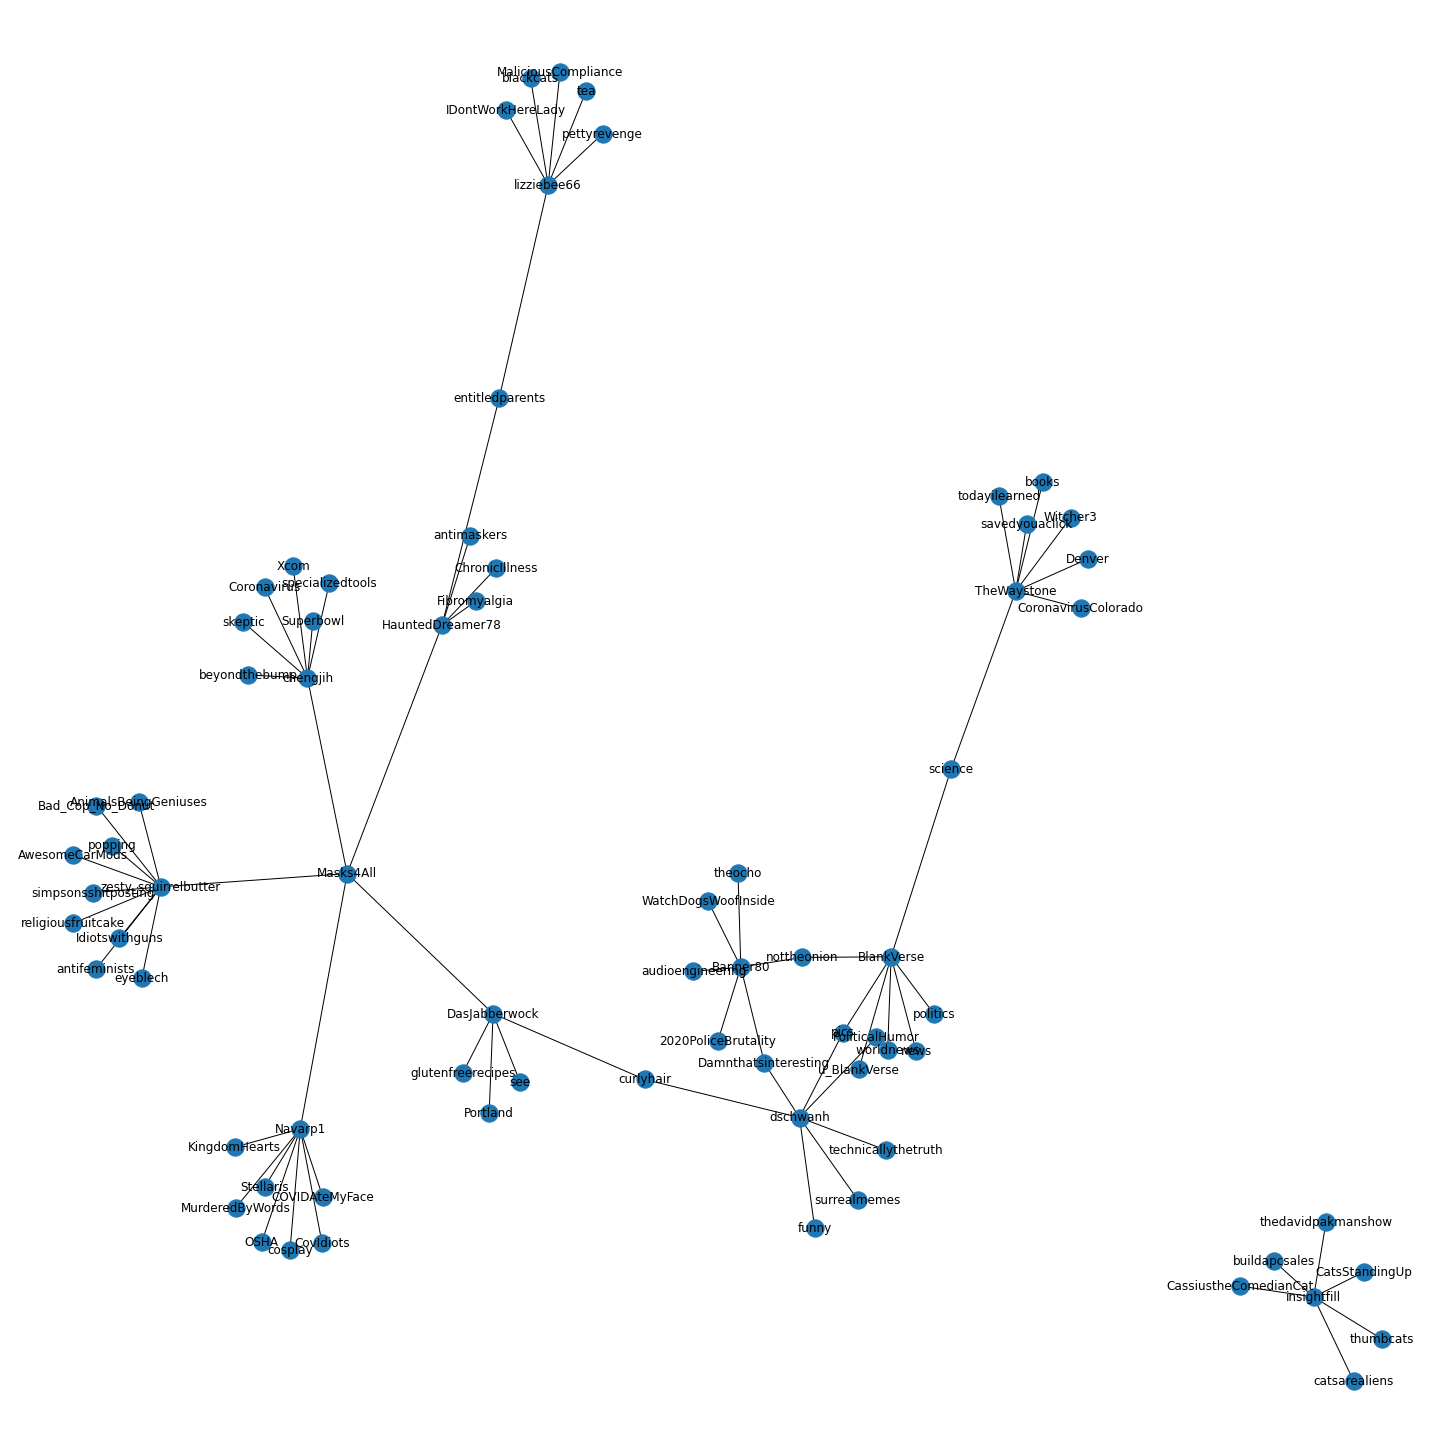

In [159]:
# load the graph
plt.figure(figsize=(20, 20))
g = nx.from_pandas_edgelist(n_df, source='author', target='subreddit') 
# visualize the graph
nx.draw(g, with_labels = True)


In [160]:
def edge_to_remove(graph):
  G_dict = nx.edge_betweenness_centrality(g)
  edge = ()

  # extract the edge with highest edge betweenness centrality score
  for key, value in sorted(G_dict.items(), key=lambda item: item[1], reverse = True):
      edge = key
      break

  return edge

In [161]:
def girvan_newman(graph):
	# find number of connected components
	sg = nx.connected_components(graph)
	sg_count = nx.number_connected_components(graph)

	while(sg_count == 1):
		graph.remove_edge(edge_to_remove(graph)[0], edge_to_remove(graph)[1])
		sg = nx.connected_components(graph)
		sg_count = nx.number_connected_components(graph)

	return sg

In [163]:
# find communities in the graph
c = girvan_newman(g.copy())

# find the nodes forming the communities
node_groups = []

for i in c:
  node_groups.append(list(i))
node_groups

[['skeptic',
  'science',
  'eyeblech',
  'entitledparents',
  'Portland',
  'see',
  'OSHA',
  'Masks4All',
  'CovIdiots',
  'DasJabberwock',
  'Denver',
  'todayilearned',
  'AnimalsBeingGeniuses',
  'KingdomHearts',
  'theocho',
  'audioengineering',
  'religiousfruitcake',
  'WatchDogsWoofInside',
  'technicallythetruth',
  'Xcom',
  'chengjih',
  'glutenfreerecipes',
  'AwesomeCarMods',
  'simpsonsshitposting',
  'worldnews',
  'Navarp1',
  'IDontWorkHereLady',
  'COVIDAteMyFace',
  'surrealmemes',
  'curlyhair',
  'nottheonion',
  'beyondthebump',
  'politics',
  'books',
  'Witcher3',
  'dschwanh',
  'Banner80',
  'popping',
  'CoronavirusColorado',
  'Fibromyalgia',
  'antimaskers',
  'pics',
  'antifeminists',
  'MaliciousCompliance',
  'MurderedByWords',
  'pettyrevenge',
  '2020PoliceBrutality',
  'cosplay',
  'HauntedDreamer78',
  'lizziebee66',
  'BlankVerse',
  'blackcats',
  'Stellaris',
  'Coronavirus',
  'ChronicIllness',
  'Idiotswithguns',
  'PoliticalHumor',
  'u_Bl

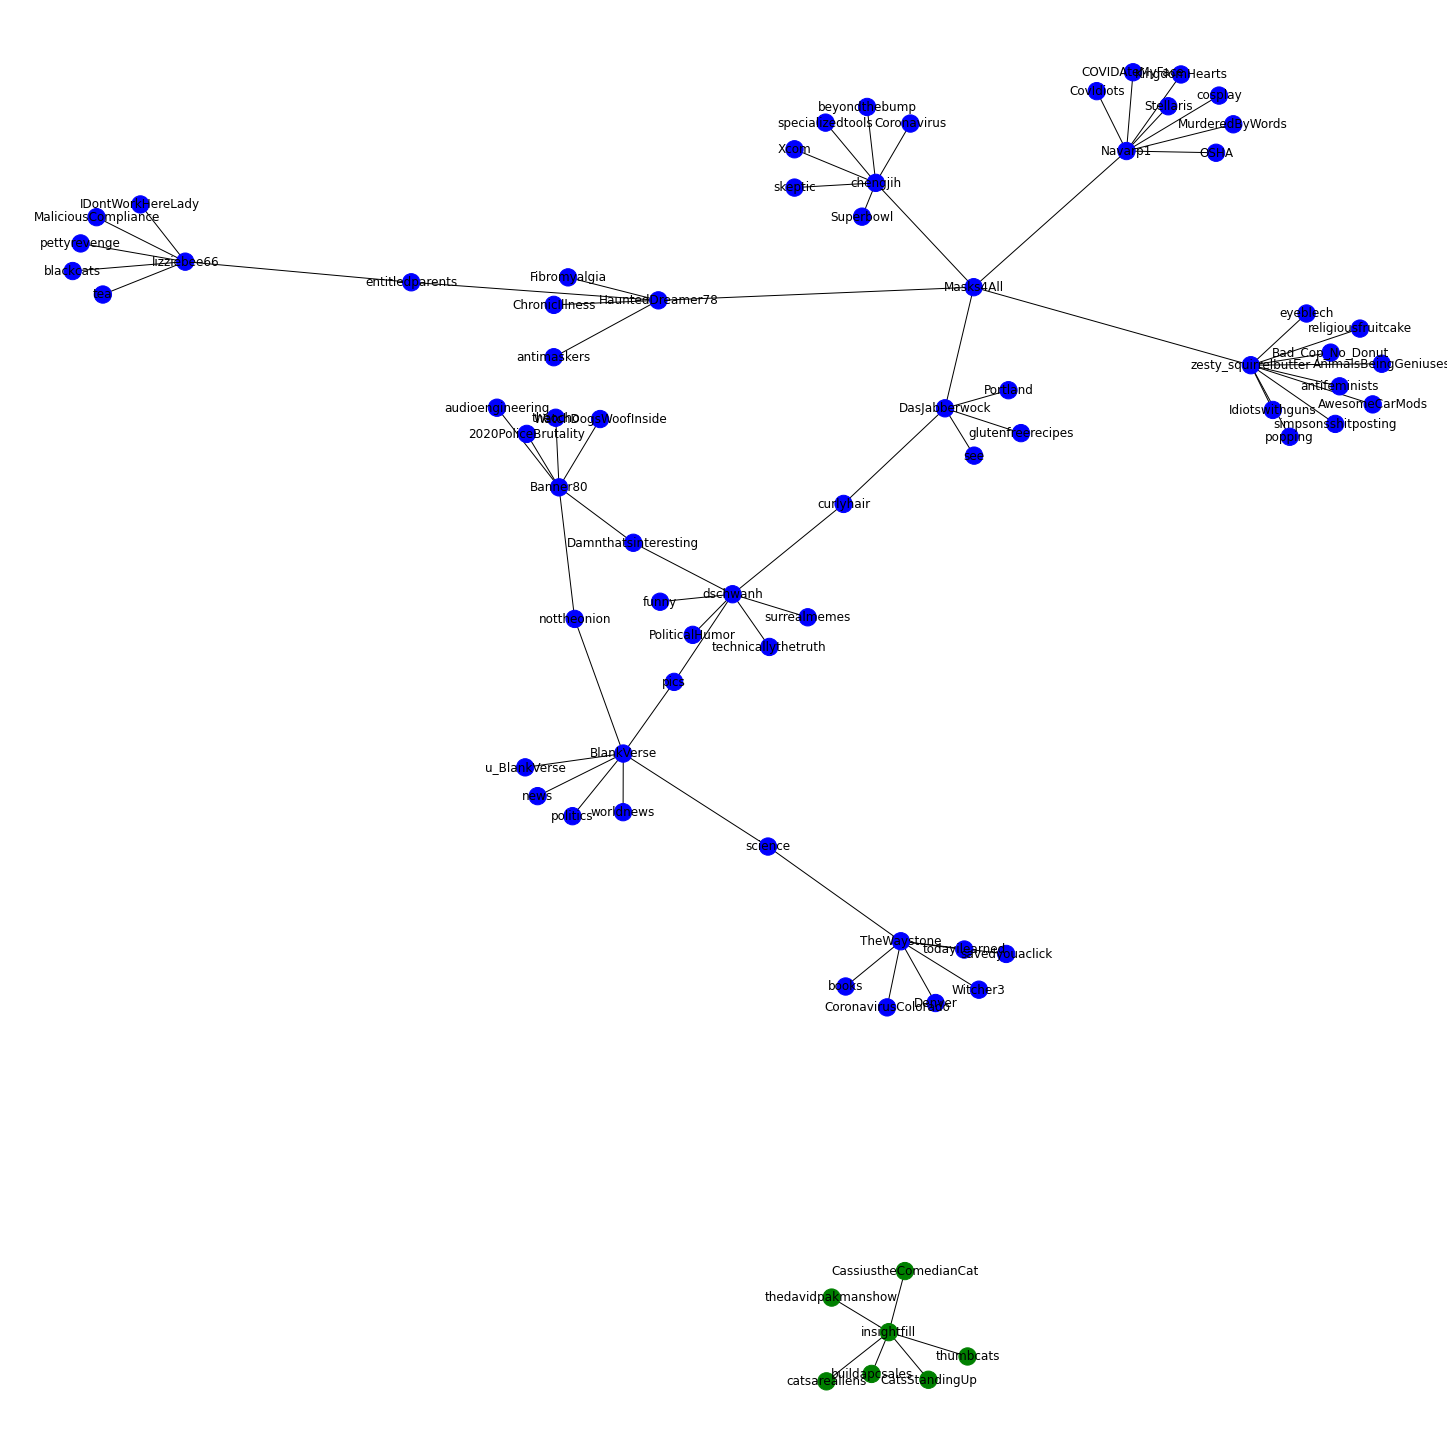

In [165]:
# plot the communities
plt.figure(figsize=(20, 20))
color_map = []
for node in g:
    if node in node_groups[0]:
        color_map.append('blue')
    else: 
        color_map.append('green')  

nx.draw(g, node_color=color_map, with_labels=True)
plt.show()

# Subreddit 3

In [77]:
import matplotlib.pyplot as plt

In [216]:
marvel_df = get_posts('covid19_support', 100) # This is where you can define any subreddit and 
                                            # run all the cells to get the network graph

In [217]:
marvel_df.author.nunique() # Out of 500, 373(new_NUMBER_SANKU) are unique 

76

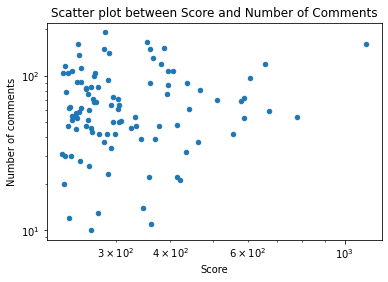

In [218]:
# See the relationship between comments and upvotes 
ax = marvel_df.plot('score', 'num_comments', kind = 'scatter',logx=True, logy=True, title='Scatter plot between Score and Number of Comments')
ax.set(xlabel="Score", ylabel="Number of comments")
plt.savefig("ScatterPlot",dpi=150, bbox_inches='tight',pad_inches=0.5)

In [219]:
repeating = marvel_df[marvel_df.duplicated(['author'], keep = False)] # Only take users who posted more than once

In [220]:
repeating = repeating[repeating.author != 'None'] # Get rid of deleted users

In [221]:
repeating.author.nunique() # Out of 500 posts, this is the amount of people who posted more than once 

12

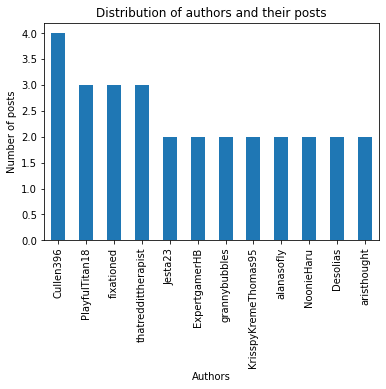

In [222]:
# See the distrubution of authors and their posts
ax = repeating.author.value_counts().plot(kind='bar',title='Distribution of authors and their posts') 
ax.set(xlabel="Authors", ylabel="Number of posts")
plt.savefig("Bargraph",dpi=150, bbox_inches='tight',pad_inches=0.5)

In [223]:
# Compiling a list of authors that appeared more than once on subreddit's top of all times 
# (Used for network graph and for get_user_posts function)
u_authors = list(repeating.author.unique()) 

In [224]:
authors_df =  pd.DataFrame() # Makes an empty dataframe
authors_df = authors_df.fillna(0)
for u in u_authors: # Loops through every "influencer" user and gets 10 top posts per user
    c = get_user_posts(u, 10)
    authors_df = pd.concat([authors_df, c]) 

In [225]:
authors_df = authors_df.rename(index=str, #renaming column names 
                               columns={0: "id", 1: "score", 2: "author", 3: "num_comments", 4: "subreddit"})

In [226]:
authors_df.head(10) # Dataframe of other subreddits where authors posted 

id  score         author  num_comments            subreddit
0  seox6s   1441  ExpertgamerHB            15           Superstonk
1  iylct9   1212  ExpertgamerHB           105  TalesFromYourServer
2  bzb4vy   1155  ExpertgamerHB            23       casualnintendo
3  u7wmcf   1154  ExpertgamerHB            13           Superstonk
4  fj8s6n   1112  ExpertgamerHB           161      COVID19_support
5  l1lyio   1038  ExpertgamerHB            23              dndmaps
6  m5u7nz    860  ExpertgamerHB            52             amcstock
7  l1ikwa    797  ExpertgamerHB            68        CurseofStrahd
8  l1lx3v    731  ExpertgamerHB            29           battlemaps
9  dnhhup    504  ExpertgamerHB            12  intermittentfasting

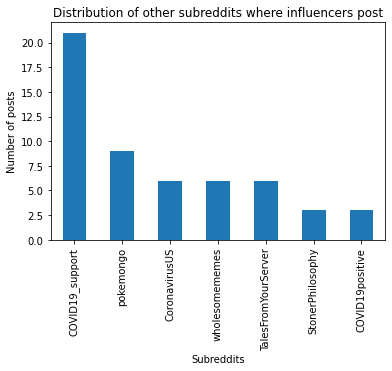

In [227]:
counts = authors_df['subreddit'].value_counts() 
# Only plot the subreddits that appear more than twice
ax = authors_df[authors_df['subreddit'].isin(counts[counts > 2].index)].subreddit.value_counts().plot(kind='bar',title='Distribution of other subreddits where influencers post') 
ax.set(xlabel="Subreddits", ylabel="Number of posts")
plt.savefig("BargraphSubreddits",dpi=150, bbox_inches='tight',pad_inches=0.5)

# Network Analysis

## Initial approach

In [228]:
n_df = authors_df[['author', 'subreddit']] # Create a dataframe for network graph purposes 
n_df.head()

author            subreddit
0  ExpertgamerHB           Superstonk
1  ExpertgamerHB  TalesFromYourServer
2  ExpertgamerHB       casualnintendo
3  ExpertgamerHB           Superstonk
4  ExpertgamerHB      COVID19_support

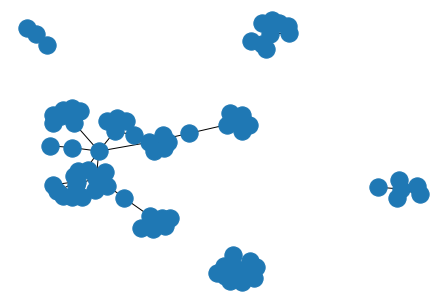

In [229]:
g = nx.from_pandas_edgelist(n_df, source='author', target='subreddit') # Initial ugly approach, decided to keep it
nx.draw(g)

## Final Approach

In [230]:
subs = list(n_df.subreddit.unique()) # Make list of unique subreddits to use in network graph 

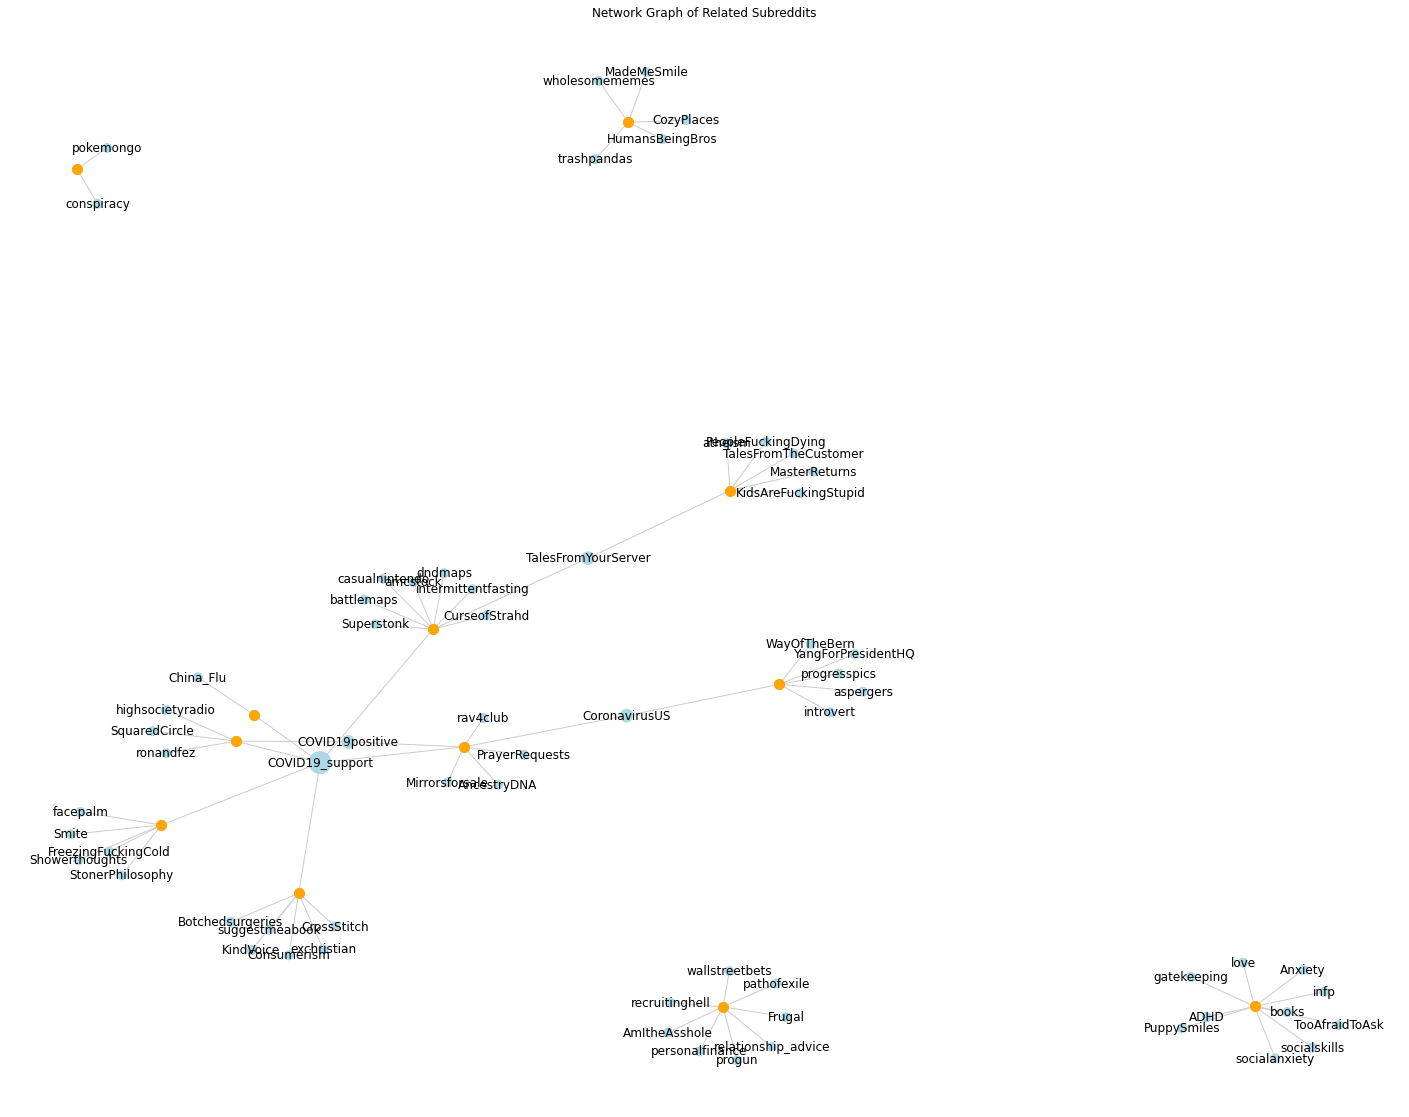

In [231]:
plt.figure(figsize=(25, 20))

# Create the graph from the dataframe
g = nx.from_pandas_edgelist(n_df, source='author', target='subreddit') 

# Create a layout for nodes 
layout = nx.spring_layout(g,iterations=50,scale=2)
pos=nx.spring_layout(g)

# Draw the parts we want, edges thin and grey
# Influencers appear small and grey
# Subreddits appear in blue and sized according to their respective number of connections.
# Labels for subreddits ONLY
# People who have more connections are highlighted in color 

# Go through every subbreddit, ask the graph how many connections it has. 
# Multiply that by 80 to get the circle size
sub_size = [g.degree(sub) * 80 for sub in subs]
nx.draw_networkx_nodes(g, 
                       layout, 
                       nodelist=subs, 
                       node_size=sub_size, # a LIST of sizes, based on g.degree
                       node_color='lightblue')

# Draw all the entities 
nx.draw_networkx_nodes(g, layout, nodelist=u_authors, node_color='#cccccc', node_size=100)

# Draw highly connected influencers 
popular_people = [person for person in u_authors if g.degree(person) > 1]
nx.draw_networkx_nodes(g, layout, nodelist=popular_people, node_color='orange', node_size=100)

nx.draw_networkx_edges(g, layout, width=1, edge_color="#cccccc")

node_labels = dict(zip(subs, subs)) #labels for subs
nx.draw_networkx_labels(g, layout, labels=node_labels)
nx.draw_networkx(g.subgraph('cosplay'),pos=pos,node_color='red')

# No axis needed
plt.axis('off')
plt.title("Network Graph of Related Subreddits")
plt.savefig("NetworkGraph", bbox_inches='tight',pad_inches=0.8)
plt.show()

In [232]:
g.degree('COVID19_support') # To check the number of out-degrees for a subreddit, if interested 

6

In [233]:
from itertools import islice

def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

In [234]:
a=nx.degree_centrality(g)
print(a)

{'ExpertgamerHB': 0.11842105263157894, 'Superstonk': 0.013157894736842105, 'TalesFromYourServer': 0.02631578947368421, 'casualnintendo': 0.013157894736842105, 'COVID19_support': 0.07894736842105263, 'dndmaps': 0.013157894736842105, 'amcstock': 0.013157894736842105, 'CurseofStrahd': 0.013157894736842105, 'battlemaps': 0.013157894736842105, 'intermittentfasting': 0.013157894736842105, 'alanasofly': 0.09210526315789473, 'CoronavirusUS': 0.02631578947368421, 'COVID19positive': 0.02631578947368421, 'AncestryDNA': 0.013157894736842105, 'Mirrorsforsale': 0.013157894736842105, 'rav4club': 0.013157894736842105, 'PrayerRequests': 0.013157894736842105, 'grannybubbles': 0.07894736842105263, 'KidsAreFuckingStupid': 0.013157894736842105, 'MasterReturns': 0.013157894736842105, 'atheism': 0.013157894736842105, 'TalesFromTheCustomer': 0.013157894736842105, 'PeopleFuckingDying': 0.013157894736842105, 'Cullen396': 0.06578947368421052, 'highsocietyradio': 0.013157894736842105, 'ronandfez': 0.0131578947368

In [235]:
b=nx.closeness_centrality(g)
print(b)

{'ExpertgamerHB': 0.2270764802631579, 'Superstonk': 0.16704476709013916, 'TalesFromYourServer': 0.17941845354126057, 'casualnintendo': 0.16704476709013916, 'COVID19_support': 0.26423444976076554, 'dndmaps': 0.16704476709013916, 'amcstock': 0.16704476709013916, 'CurseofStrahd': 0.16704476709013916, 'battlemaps': 0.16704476709013916, 'intermittentfasting': 0.16704476709013916, 'alanasofly': 0.22019537480063797, 'CoronavirusUS': 0.1750951173113507, 'COVID19positive': 0.17097523219814242, 'AncestryDNA': 0.1632909520993495, 'Mirrorsforsale': 0.1632909520993495, 'rav4club': 0.1632909520993495, 'PrayerRequests': 0.1632909520993495, 'grannybubbles': 0.14679691653375865, 'KidsAreFuckingStupid': 0.11912208800690251, 'MasterReturns': 0.11912208800690251, 'atheism': 0.11912208800690251, 'TalesFromTheCustomer': 0.11912208800690251, 'PeopleFuckingDying': 0.11912208800690251, 'Cullen396': 0.1963904694167852, 'highsocietyradio': 0.14982365708084647, 'ronandfez': 0.14982365708084647, 'SquaredCircle': 0

In [236]:
c=nx.betweenness_centrality(g)
print(c)

{'ExpertgamerHB': 0.18666666666666665, 'Superstonk': 0.0, 'TalesFromYourServer': 0.0863157894736842, 'casualnintendo': 0.0, 'COVID19_support': 0.2901754385964912, 'dndmaps': 0.0, 'amcstock': 0.0, 'CurseofStrahd': 0.0, 'battlemaps': 0.0, 'intermittentfasting': 0.0, 'alanasofly': 0.15631578947368419, 'CoronavirusUS': 0.0863157894736842, 'COVID19positive': 0.008421052631578947, 'AncestryDNA': 0.0, 'Mirrorsforsale': 0.0, 'rav4club': 0.0, 'PrayerRequests': 0.0, 'grannybubbles': 0.07719298245614034, 'KidsAreFuckingStupid': 0.0, 'MasterReturns': 0.0, 'atheism': 0.0, 'TalesFromTheCustomer': 0.0, 'PeopleFuckingDying': 0.0, 'Cullen396': 0.05280701754385964, 'highsocietyradio': 0.0, 'ronandfez': 0.0, 'SquaredCircle': 0.0, 'thatreddittherapist': 0.016140350877192983, 'China_Flu': 0.0, 'aristhought': 0.003508771929824561, 'wholesomememes': 0.0, 'HumansBeingBros': 0.0, 'MadeMeSmile': 0.0, 'CozyPlaces': 0.0, 'trashpandas': 0.0, 'Desolias': 0.07719298245614034, 'FreezingFuckingCold': 0.0, 'StonerPhilo

In [98]:
d=nx.edge_betweenness_centrality(g)
print(d)

{('zesty_squirrelbutter', 'popping'): 0.024144144144144144, ('zesty_squirrelbutter', 'religiousfruitcake'): 0.024144144144144144, ('zesty_squirrelbutter', 'AwesomeCarMods'): 0.024144144144144144, ('zesty_squirrelbutter', 'AnimalsBeingGeniuses'): 0.024144144144144144, ('zesty_squirrelbutter', 'antifeminists'): 0.024144144144144144, ('zesty_squirrelbutter', 'eyeblech'): 0.024144144144144144, ('zesty_squirrelbutter', 'simpsonsshitposting'): 0.024144144144144144, ('zesty_squirrelbutter', 'Bad_Cop_No_Donut'): 0.024144144144144144, ('zesty_squirrelbutter', 'Masks4All'): 0.209009009009009, ('zesty_squirrelbutter', 'Idiotswithguns'): 0.024144144144144144, ('Masks4All', 'DasJabberwock'): 0.41333333333333333, ('Masks4All', 'HauntedDreamer78'): 0.22594594594594594, ('Masks4All', 'chengjih'): 0.15387387387387388, ('Masks4All', 'Navarp1'): 0.17297297297297298, ('dschwanh', 'pics'): 0.2491891891891892, ('dschwanh', 'PoliticalHumor'): 0.024144144144144144, ('dschwanh', 'Damnthatsinteresting'): 0.1136

In [237]:
e=nx.voterank(g)
print(e)

['fixationed', 'ExpertgamerHB', 'Jesta23', 'alanasofly', 'NoonieHaru', 'grannybubbles', 'KrisspyKremeThomas95', 'aristhought', 'Desolias', 'Cullen396', 'PlayfulTitan18', 'COVID19_support', 'thatreddittherapist']


In [238]:
f=nx.pagerank(g)
print(f)

{'ExpertgamerHB': 0.05375514871318803, 'Superstonk': 0.007024560194917325, 'TalesFromYourServer': 0.012567049133505115, 'casualnintendo': 0.007024560194917325, 'COVID19_support': 0.032941171311936024, 'dndmaps': 0.007024560194917325, 'amcstock': 0.007024560194917325, 'CurseofStrahd': 0.007024560194917325, 'battlemaps': 0.007024560194917325, 'intermittentfasting': 0.007024560194917325, 'alanasofly': 0.039984001054117736, 'CoronavirusUS': 0.012305863558620124, 'COVID19positive': 0.011781012521329182, 'AncestryDNA': 0.0068028899813453395, 'Mirrorsforsale': 0.0068028899813453395, 'rav4club': 0.0068028899813453395, 'PrayerRequests': 0.0068028899813453395, 'grannybubbles': 0.03912608139558967, 'KidsAreFuckingStupid': 0.007490540886639739, 'MasterReturns': 0.007490540886639739, 'atheism': 0.007490540886639739, 'TalesFromTheCustomer': 0.007490540886639739, 'PeopleFuckingDying': 0.007490540886639739, 'Cullen396': 0.029285204123178348, 'highsocietyradio': 0.006926174488035792, 'ronandfez': 0.006

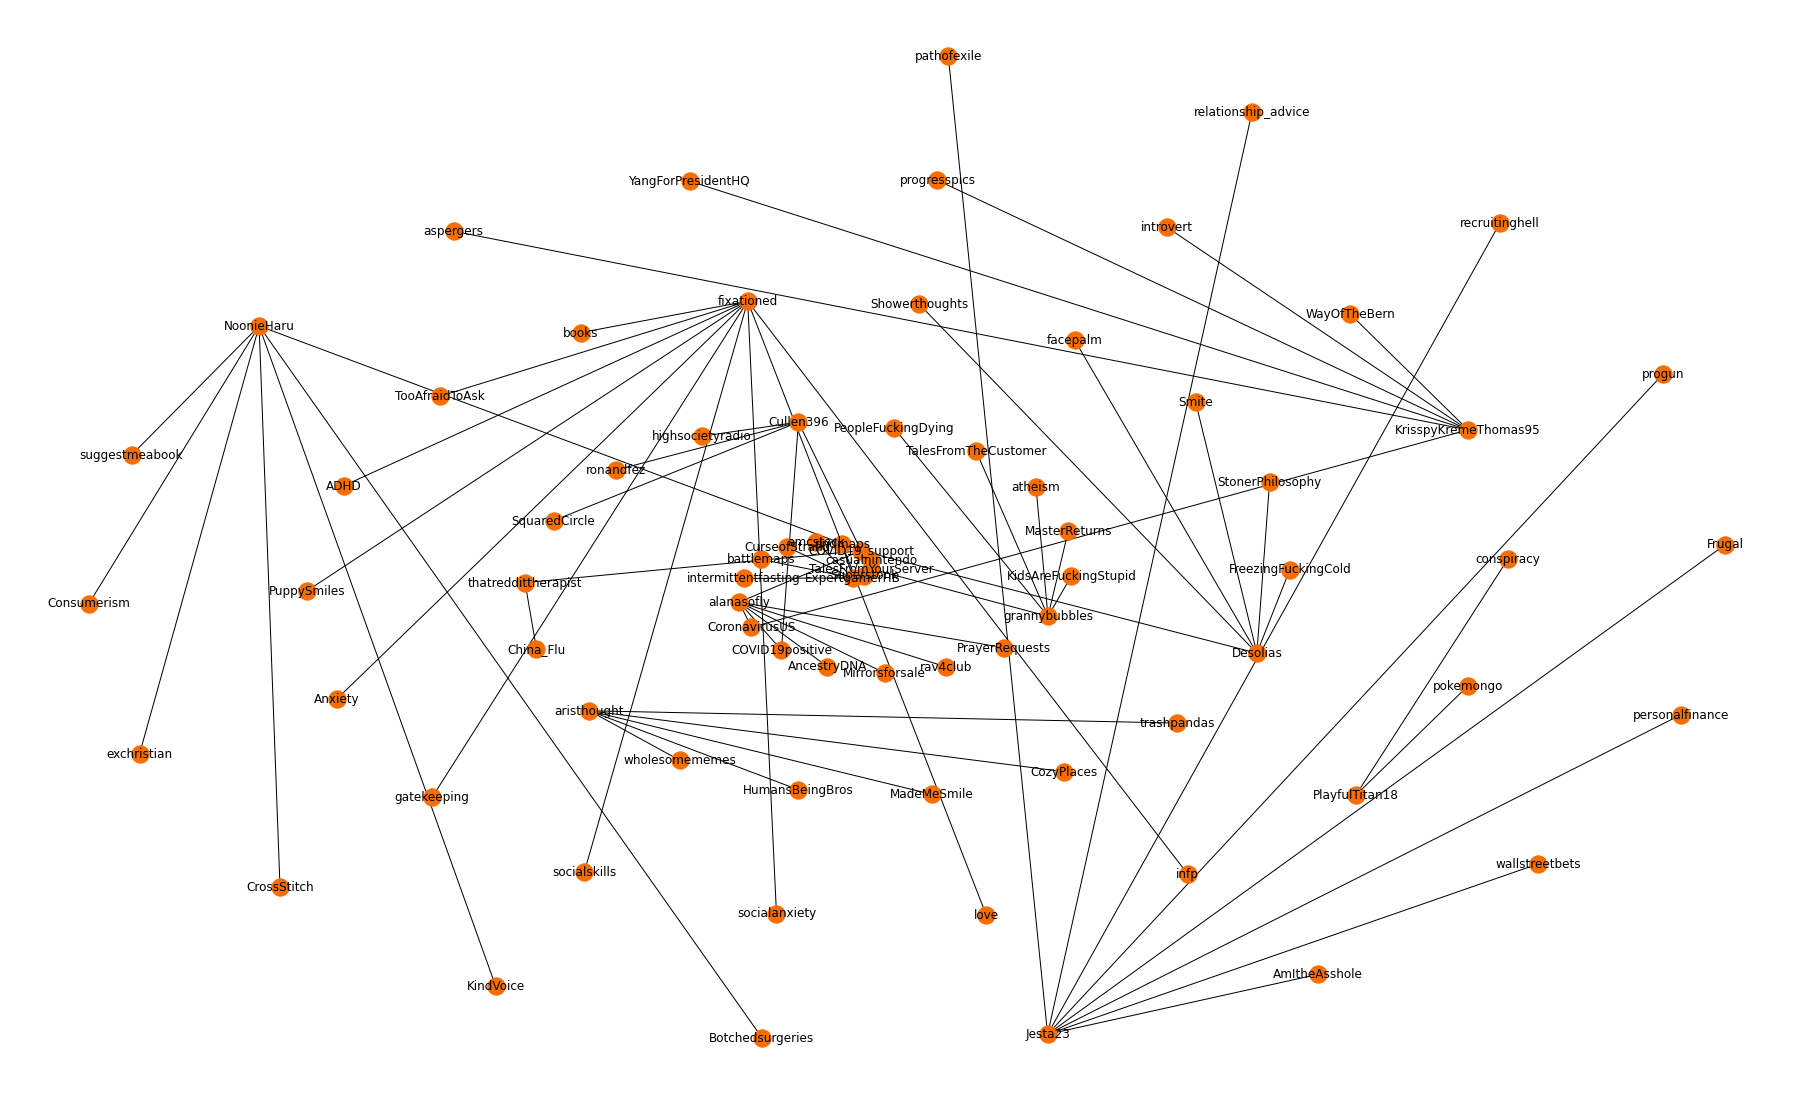

In [242]:
pos = nx.spiral_layout(g)
plt.figure(figsize=(25,15))
nx.draw(g, pos, with_labels = True, node_color="#f86e00")
plt.show()

<BarContainer object of 77 artists>

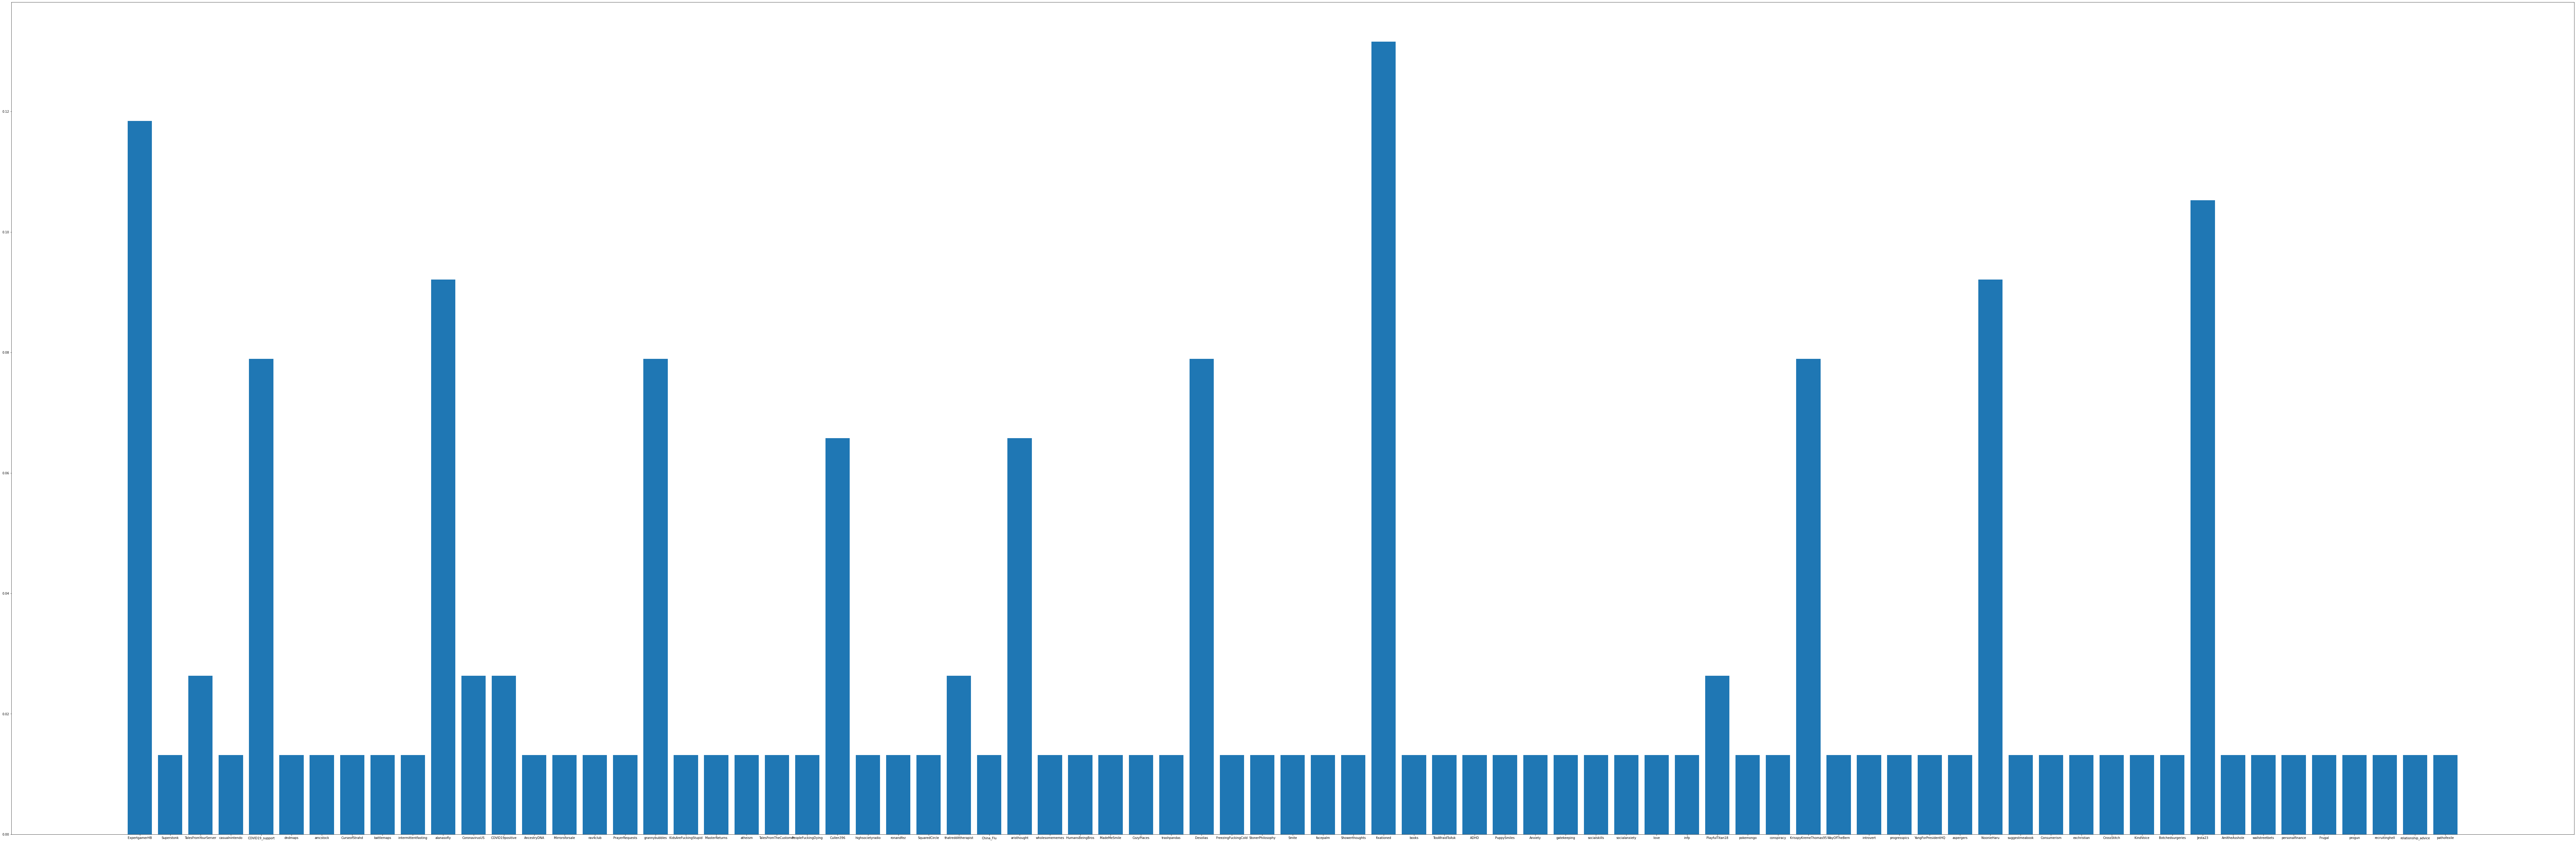

In [243]:
names, counts = zip(*a.items())
plt.figure(figsize=(150,50))
plt.bar(names, counts)

In [131]:
from datetime import datetime
time_format = "%d%b%Y %H:%M"
datetime.now().strftime(time_format)

'23Apr2022 11:21'

# Link Prediction

In [244]:
preds = nx.resource_allocation_index(g)
cnt=0
m=0
for u, v, p in preds:
    if p>m:
      m=p
      pair=(u,v)
    print(f"({u}, {v}) -> {p:.8f}")
    cnt=cnt+1
    if cnt==100:
      break
print(f"Max value : {pair} -> {m:.8f}")

(grannybubbles, socialskills) -> 0.00000000
(grannybubbles, CurseofStrahd) -> 0.00000000
(grannybubbles, gatekeeping) -> 0.00000000
(grannybubbles, amcstock) -> 0.00000000
(grannybubbles, wholesomememes) -> 0.00000000
(grannybubbles, aristhought) -> 0.00000000
(grannybubbles, introvert) -> 0.00000000
(grannybubbles, books) -> 0.00000000
(grannybubbles, love) -> 0.00000000
(grannybubbles, battlemaps) -> 0.00000000
(grannybubbles, NoonieHaru) -> 0.00000000
(grannybubbles, highsocietyradio) -> 0.00000000
(grannybubbles, socialanxiety) -> 0.00000000
(grannybubbles, MadeMeSmile) -> 0.00000000
(grannybubbles, wallstreetbets) -> 0.00000000
(grannybubbles, progresspics) -> 0.00000000
(grannybubbles, HumansBeingBros) -> 0.00000000
(grannybubbles, COVID19positive) -> 0.00000000
(grannybubbles, PlayfulTitan18) -> 0.00000000
(grannybubbles, facepalm) -> 0.00000000
(grannybubbles, ronandfez) -> 0.00000000
(grannybubbles, SquaredCircle) -> 0.00000000
(grannybubbles, China_Flu) -> 0.00000000
(grannyb

# Jaccard Coefficient

In [245]:
preds = nx.jaccard_coefficient(g)
cnt=0
m=0
for u, v, p in preds:
    if p>m:
      m=p
      pair=(u,v)
    print(f"({u}, {v}) -> {p:.8f}")
    cnt=cnt+1
    if cnt==100:
      break
print(f"Max value : {pair} -> {m:.8f}")

(grannybubbles, socialskills) -> 0.00000000
(grannybubbles, CurseofStrahd) -> 0.00000000
(grannybubbles, gatekeeping) -> 0.00000000
(grannybubbles, amcstock) -> 0.00000000
(grannybubbles, wholesomememes) -> 0.00000000
(grannybubbles, aristhought) -> 0.00000000
(grannybubbles, introvert) -> 0.00000000
(grannybubbles, books) -> 0.00000000
(grannybubbles, love) -> 0.00000000
(grannybubbles, battlemaps) -> 0.00000000
(grannybubbles, NoonieHaru) -> 0.00000000
(grannybubbles, highsocietyradio) -> 0.00000000
(grannybubbles, socialanxiety) -> 0.00000000
(grannybubbles, MadeMeSmile) -> 0.00000000
(grannybubbles, wallstreetbets) -> 0.00000000
(grannybubbles, progresspics) -> 0.00000000
(grannybubbles, HumansBeingBros) -> 0.00000000
(grannybubbles, COVID19positive) -> 0.00000000
(grannybubbles, PlayfulTitan18) -> 0.00000000
(grannybubbles, facepalm) -> 0.00000000
(grannybubbles, ronandfez) -> 0.00000000
(grannybubbles, SquaredCircle) -> 0.00000000
(grannybubbles, China_Flu) -> 0.00000000
(grannyb

## Adamic–Adar index

In [246]:
preds = nx.adamic_adar_index(g)
cnt=0
m=0
for u, v, p in preds:
    if p>m:
      m=p
      pair=(u,v)
    print(f"({u}, {v}) -> {p:.8f}")
    cnt=cnt+1
    if cnt==100:
      break
print(f"Max value : {pair} -> {m:.8f}")

(grannybubbles, socialskills) -> 0.00000000
(grannybubbles, CurseofStrahd) -> 0.00000000
(grannybubbles, gatekeeping) -> 0.00000000
(grannybubbles, amcstock) -> 0.00000000
(grannybubbles, wholesomememes) -> 0.00000000
(grannybubbles, aristhought) -> 0.00000000
(grannybubbles, introvert) -> 0.00000000
(grannybubbles, books) -> 0.00000000
(grannybubbles, love) -> 0.00000000
(grannybubbles, battlemaps) -> 0.00000000
(grannybubbles, NoonieHaru) -> 0.00000000
(grannybubbles, highsocietyradio) -> 0.00000000
(grannybubbles, socialanxiety) -> 0.00000000
(grannybubbles, MadeMeSmile) -> 0.00000000
(grannybubbles, wallstreetbets) -> 0.00000000
(grannybubbles, progresspics) -> 0.00000000
(grannybubbles, HumansBeingBros) -> 0.00000000
(grannybubbles, COVID19positive) -> 0.00000000
(grannybubbles, PlayfulTitan18) -> 0.00000000
(grannybubbles, facepalm) -> 0.00000000
(grannybubbles, ronandfez) -> 0.00000000
(grannybubbles, SquaredCircle) -> 0.00000000
(grannybubbles, China_Flu) -> 0.00000000
(grannyb

## Preferential attachment 

In [247]:
preds = nx.preferential_attachment(g)
cnt=0
m=0
for u, v, p in preds:
    if p>m:
      m=p
      pair=(u,v)
    print(f"({u}, {v}) -> {p:.8f}")
    cnt=cnt+1
    if cnt==200:
      break
print(f"Max value : {pair} -> {m:.8f}")

(grannybubbles, socialskills) -> 6.00000000
(grannybubbles, CurseofStrahd) -> 6.00000000
(grannybubbles, gatekeeping) -> 6.00000000
(grannybubbles, amcstock) -> 6.00000000
(grannybubbles, wholesomememes) -> 6.00000000
(grannybubbles, aristhought) -> 30.00000000
(grannybubbles, introvert) -> 6.00000000
(grannybubbles, books) -> 6.00000000
(grannybubbles, love) -> 6.00000000
(grannybubbles, battlemaps) -> 6.00000000
(grannybubbles, NoonieHaru) -> 42.00000000
(grannybubbles, highsocietyradio) -> 6.00000000
(grannybubbles, socialanxiety) -> 6.00000000
(grannybubbles, MadeMeSmile) -> 6.00000000
(grannybubbles, wallstreetbets) -> 6.00000000
(grannybubbles, progresspics) -> 6.00000000
(grannybubbles, HumansBeingBros) -> 6.00000000
(grannybubbles, COVID19positive) -> 12.00000000
(grannybubbles, PlayfulTitan18) -> 12.00000000
(grannybubbles, facepalm) -> 6.00000000
(grannybubbles, ronandfez) -> 6.00000000
(grannybubbles, SquaredCircle) -> 6.00000000
(grannybubbles, China_Flu) -> 6.00000000
(gra

## Louvain Community Detection 

In [248]:
!pip install community

In [249]:
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms.community.centrality import girvan_newman

# Girvan Newman

In [250]:
import networkx as nx
import matplotlib.pyplot as plt

%matplotlib inline

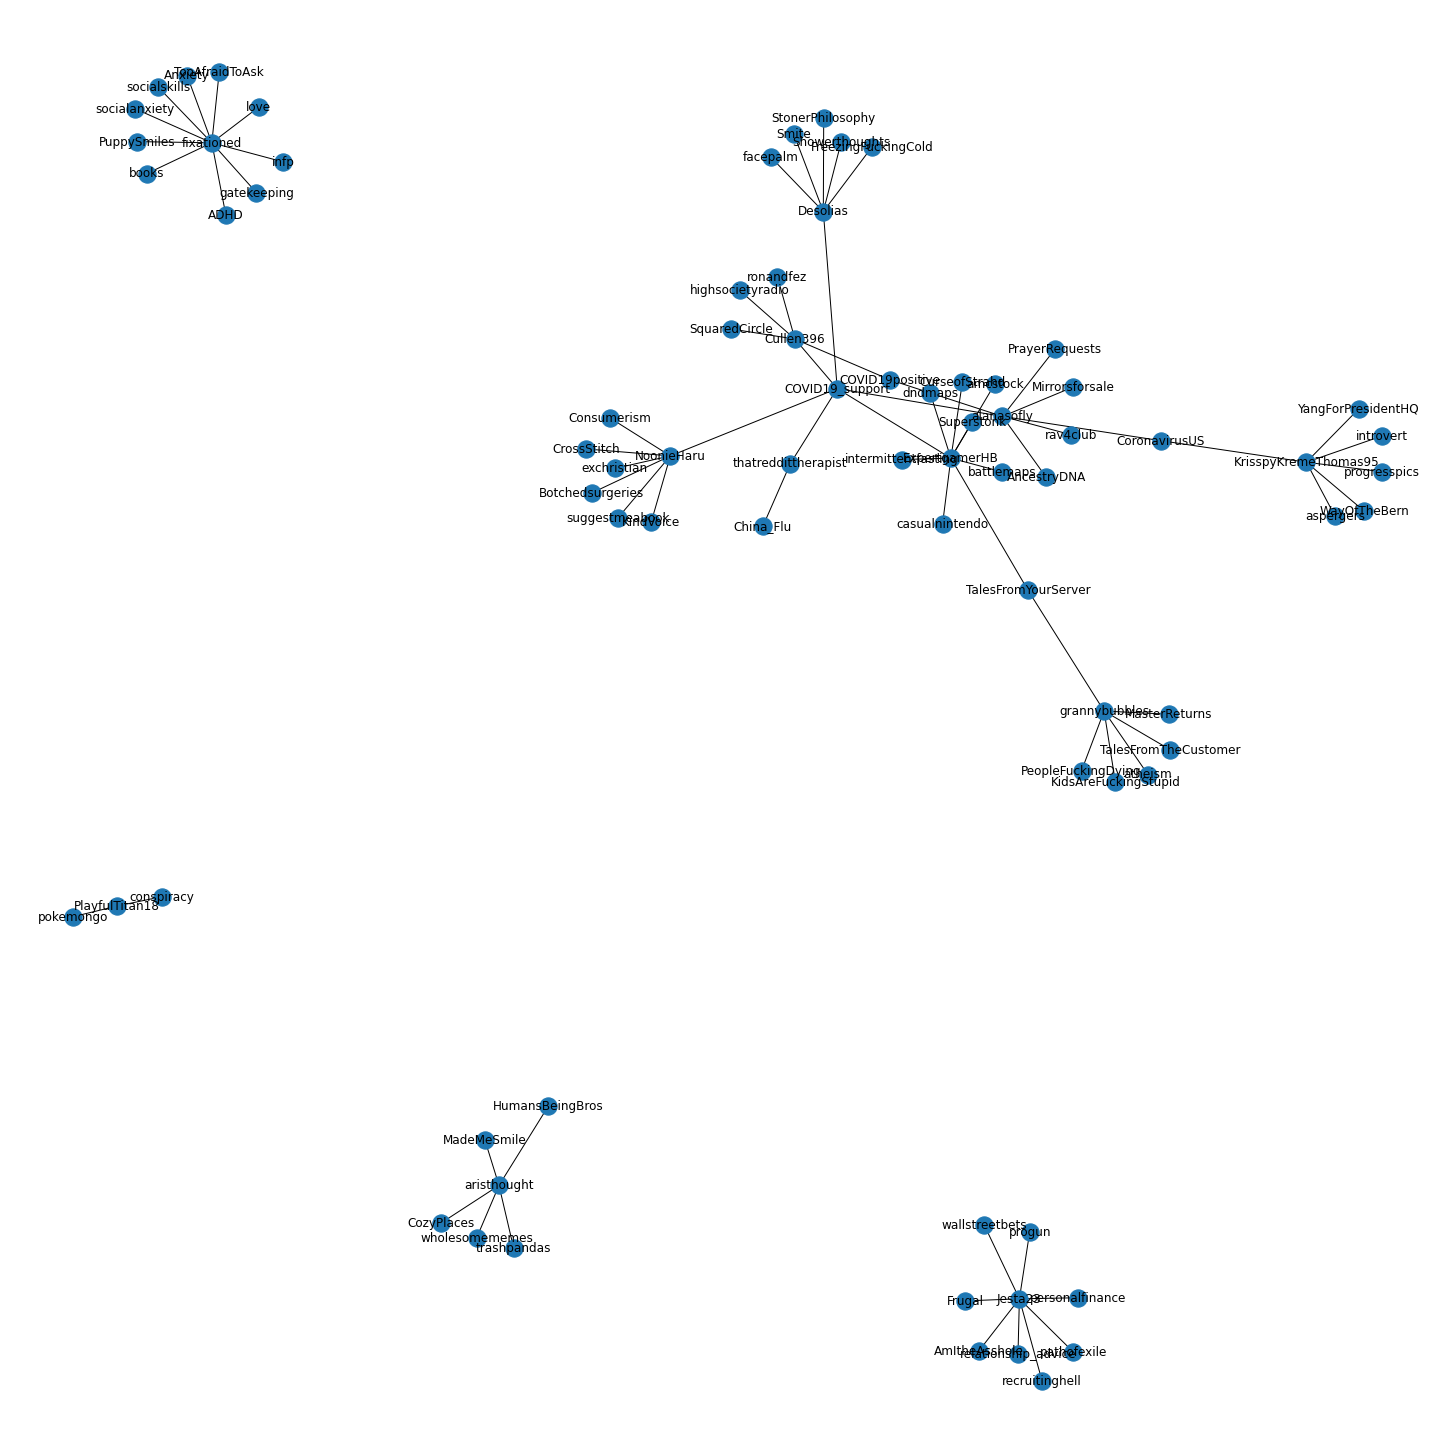

In [251]:
# load the graph
plt.figure(figsize=(20, 20))
g = nx.from_pandas_edgelist(n_df, source='author', target='subreddit') 
# visualize the graph
nx.draw(g, with_labels = True)


In [252]:
def edge_to_remove(graph):
  G_dict = nx.edge_betweenness_centrality(g)
  edge = ()

  # extract the edge with highest edge betweenness centrality score
  for key, value in sorted(G_dict.items(), key=lambda item: item[1], reverse = True):
      edge = key
      break

  return edge

In [253]:
def girvan_newman(graph):
	# find number of connected components
	sg = nx.connected_components(graph)
	sg_count = nx.number_connected_components(graph)

	while(sg_count == 1):
		graph.remove_edge(edge_to_remove(graph)[0], edge_to_remove(graph)[1])
		sg = nx.connected_components(graph)
		sg_count = nx.number_connected_components(graph)

	return sg

In [254]:
# find communities in the graph
c = girvan_newman(g.copy())

# find the nodes forming the communities
node_groups = []

for i in c:
  node_groups.append(list(i))
node_groups

[['PrayerRequests',
  'CrossStitch',
  'Botchedsurgeries',
  'CurseofStrahd',
  'grannybubbles',
  'WayOfTheBern',
  'amcstock',
  'Desolias',
  'StonerPhilosophy',
  'CoronavirusUS',
  'introvert',
  'ExpertgamerHB',
  'TalesFromTheCustomer',
  'Smite',
  'MasterReturns',
  'YangForPresidentHQ',
  'Superstonk',
  'battlemaps',
  'KidsAreFuckingStupid',
  'NoonieHaru',
  'COVID19_support',
  'suggestmeabook',
  'alanasofly',
  'exchristian',
  'highsocietyradio',
  'rav4club',
  'Cullen396',
  'aspergers',
  'AncestryDNA',
  'KindVoice',
  'intermittentfasting',
  'PeopleFuckingDying',
  'dndmaps',
  'Mirrorsforsale',
  'Consumerism',
  'progresspics',
  'COVID19positive',
  'facepalm',
  'ronandfez',
  'SquaredCircle',
  'China_Flu',
  'atheism',
  'FreezingFuckingCold',
  'TalesFromYourServer',
  'Showerthoughts',
  'casualnintendo',
  'thatreddittherapist',
  'KrisspyKremeThomas95'],
 ['wholesomememes',
  'trashpandas',
  'HumansBeingBros',
  'aristhought',
  'CozyPlaces',
  'MadeMe

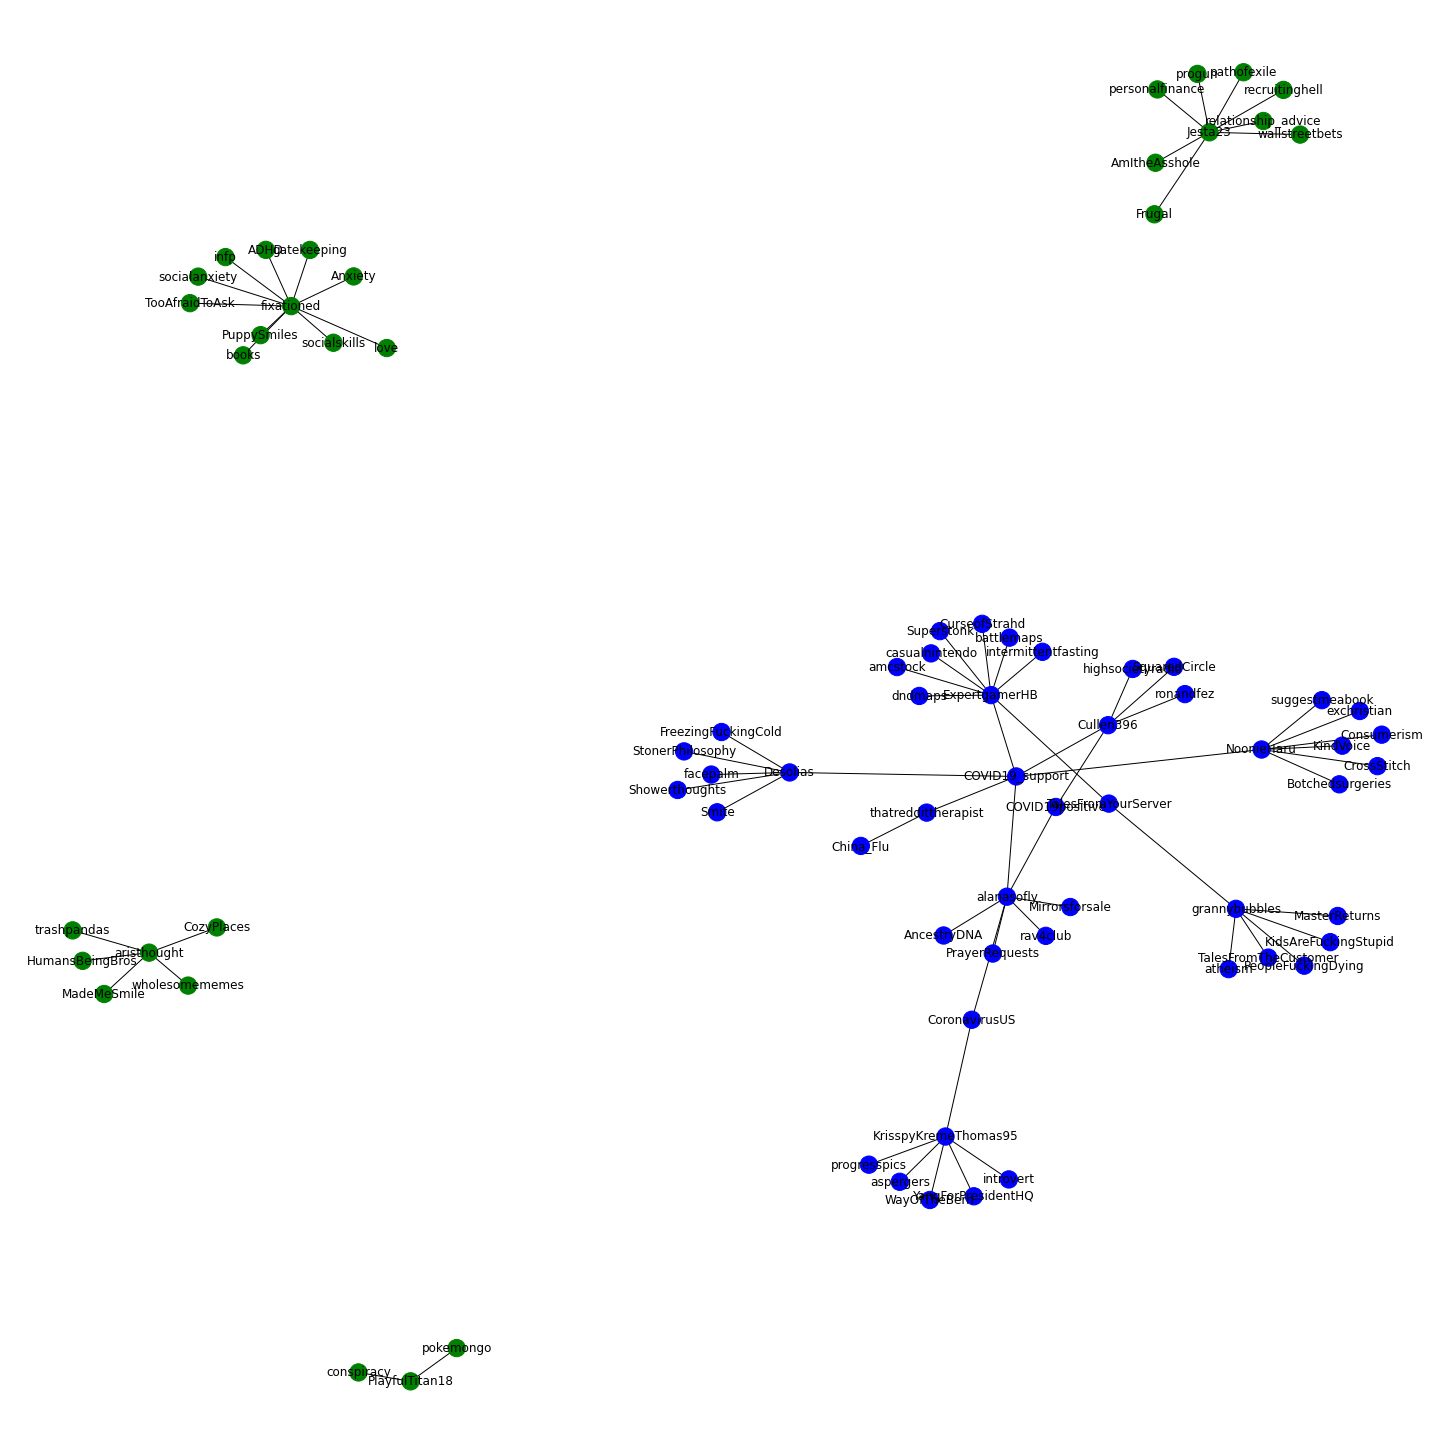

In [255]:
# plot the communities
plt.figure(figsize=(20, 20))
color_map = []
for node in g:
    if node in node_groups[0]:
        color_map.append('blue')
    else: 
        color_map.append('green')  

nx.draw(g, node_color=color_map, with_labels=True)
plt.show()